<a href="https://colab.research.google.com/github/arielwendichansky/Copa-America-Model-2024/blob/main/Copa_America_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CopaAnalyzer: Unveiling the next Copa America Champion with ML**

In the heart of every passionate football enthusiast lies an insatiable desire to witness the beautiful game's unpredictable drama unfold on the grandest stages. As an Argentine, my love for football runs deep, particularly when the pride of my nation takes center stage, led by the GOAT Lionel Messi. The 2022 World Cup victory only fueled my passion and sparked a new endeavor—to create a predictive model that forecasts the next Copa America champion.

CopaAnalyzer utilizes logistic regression to peer into the forthcoming tournament's outcome. Drawing from three primary data sources (historical games data since 2020, FIFA rankings, and team skill) this model aims to unravel the intricacies of South American football dynamics.

This project serves as the culmination of my journey through a data analytics boot camp, showcasing the application of tools and techniques acquired along the way. From data wrangling to model evaluation, each step reflects a commitment to harnessing the power of data to unlock footballing insights.

Join me as we dive into the realm of CopaAnalyzer, where analytics meets anticipation, and together, let's celebrate the enduring magic of football.

Let the ball start rolling!

# Installs

In [2]:
# Libraries to scrap info from the web
! pip install selenium
! pip install requests beautifulsoup4 pandas
# Library for ML
! pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00


In [3]:
# Library to scrap info from different websites related to football.
! pip install LanusStats
! pip install --upgrade LanusStats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.2 MB/s eta 0:00:00


In [4]:
# Gemini model
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.3 MB/s eta 0:00:00


In [5]:
! pip install pygraphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: Could not build wheels for pygraphviz, which is required to install pyproject.toml-based projects


# Libraries

In [177]:
# To know todays date
from datetime import date

# To handle the data
import pandas as pd
import numpy as np
import random
import joblib

# For web scraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import requests as re
import LanusStats as ls

# To visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# To preprocess the data and divide the data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score, classification_report, confusion_matrix, roc_auc_score

# Machine learning model
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# To suimulate games matches
from itertools import combinations

# Null values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer # For categorical values
from sklearn.impute import KNNImputer

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Gemini packages
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

# Web Scraping

Disclaimer: The website from where the data is being scraped is not static, it is dynamic meaning it is continuously updating so this might change the results extracted.

In [8]:
# URL of the webpage to scrape
url = 'https://www.ole.com.ar/copa-america/copa-america-2024-listas-convocados-argentina-messi_0_7KCGeSguIO.html'

# Send a GET request to the URL
response = re.get(url)

# Parse the HTML content of the webpage
soup = bs(response.text, 'html.parser')

# Find all div elements with class "custom-text"
news_items = soup.find_all("div", class_="custom-text")

# Create a dictionary to store the titles and content for each country
country_news = {}

# Initialize variables to store the current country and its player list
current_country = None
player_list = ""
skip_paragraph = False  # Flag to determine if the paragraph should be skipped

# Iterate through each news item
for item in news_items:
    # Find the h2 element to extract the title (country)
    title_element = item.find("h2")
    if title_element:
        # If there's a title, update the current country and reset the player list
        if current_country:
            country_news[current_country] = player_list.strip()
            player_list = ""
        current_country = title_element.text.strip()
        skip_paragraph = True  # Skip the first paragraph after the title
    else:
        # If there's no title, check if the paragraph should be skipped
        if skip_paragraph:
            skip_paragraph = False
            continue

        # Add the content to the player list
        content_paragraphs = item.find_all("p")
        player_list += "\n".join([p.text.strip() for p in content_paragraphs]) + "\n"

# Add the last country and its player list to the dictionary
if current_country:
    country_news[current_country] = player_list.strip()

# Print the dictionary with desired format
for country, players in country_news.items():
    print(country)
    print(players)
    print("----------------------")


GRUPO A
Se acerca la Copa América 2024 y las distintas selecciones definen sus planteles. Hasta acá, Brasil, Ecuador, Uruguay, Jamaica y Panamá ya anunciaron sus planteles completos con 26 jugadores para el torneo que se va a jugar en Estados Unidos. Antes y después, hubo otros seleccionados que brindaron nóminas preliminares, con jugadores por cortar como es el caso de Argentina. La fecha límite para presentar las listas es el 15 de junio.
----------------------
Argentina
Arqueros: Emiliano Martínez (Aston Villa); Franco Armani (River Plate) y Gerónimo Rulli (Ajax).
Defensores: Gonzalo Montiel (Nottingham Forest); Nahuel Molina (Atlético Madrid); Leonardo Balerdi (Olympique de Marsella); Cristian Romero (Tottenham); Germán Pezzella (Real Betis); Lucas Martínez Quarta (Fiorentina); Nicolás Otamendi (Benfica); Lisandro Martínez (Manchester United); Marcos Acuña (Sevilla); Nicolás Tagliafico (Lyon) y Valentín Barco (Brighton).
Volantes: Guido Rodríguez (Real Betis); Leandro Paredes (Roma

In [9]:
# Define a function to extract player names and teams from the player list
def extract_players_and_teams(player_list, country):
    players = []
    lines = player_list.split('\n')
    category = ""
    for line in lines:
        if line.strip() == "":
            continue
        if ":" in line:
            category = line.split(":")[0].strip()
            players_name = line.split(":")[1].strip()
            # Replace ' y ' with ';' and ',' with ';' to standardize delimiters
            players_name = players_name.replace(' y ', ';').replace(',', ';')
            player_list = players_name.split(';')
            # Clean up any leading/trailing whitespace
            for player in player_list:
                players.append((country, player.strip(), category))
    return players

player_data = []

# Iterate through each country and its player list
for country, players_list in country_news.items():
    if country.startswith('GRUPO'):
        continue
    if players_list:  # Ensure there's player data to process
        country_players = extract_players_and_teams(players_list, country)
        player_data.extend(country_players)
        print(f"{len(country_players)} players added for country: {country}")

# Create a DataFrame from the player data list
df = pd.DataFrame(player_data, columns=['Country', 'Name (Team)', 'Category'])
print(df)


29 players added for country: Argentina
16 players added for country: Perú
54 players added for country: Chile
27 players added for country: Canadá
29 players added for country: México
26 players added for country: Ecuador
47 players added for country: Venezuela
26 players added for country: Jamaica
27 players added for country: Estados Unidos
24 players added for country: Uruguay
27 players added for country: Panamá
28 players added for country: Bolivia
26 players added for country: Brasil
28 players added for country: Colombia
27 players added for country: Paraguay
27 players added for country: Costa Rica
        Country                          Name (Team)    Category
0     Argentina      Emiliano Martínez (Aston Villa)    Arqueros
1     Argentina          Franco Armani (River Plate)    Arqueros
2     Argentina               Gerónimo Rulli (Ajax).    Arqueros
3     Argentina  Gonzalo Montiel (Nottingham Forest)  Defensores
4     Argentina      Nahuel Molina (Atlético Madrid)  Defens

From the website where the list of player where extracted some players does not have a ',' to divide each. Therefore, cleaning the data to have each row with a unique player is necessary.

In [10]:
# Function to split rows with multiple players and extract team names
def split_players(row):
    players = row['Name (Team)'].split(') ')
    new_rows = []
    for player in players:
        if player:
            if not player.endswith(')'):
                player
            parts = player.split(' (')
            if len(parts) == 2:
                name, team = parts
                new_rows.append([row['Country'], name.strip(), team.strip(), row['Category']])
    return new_rows

# Apply the function and create a new DataFrame
new_rows = []
for _, row in df.iterrows():
    new_rows.extend(split_players(row))

# Convert new rows into a DataFrame
new_df = pd.DataFrame(new_rows, columns=['Country', 'Name','Team', 'Position'])

# Remove ')' and '.' from 'Team' column
new_df['Team'] = new_df['Team'].str.replace(r')', '')
new_df['Team'] = new_df['Team'].str.replace(r'.', '')

# Replacing position names
new_df['Position'] = new_df['Position'].replace({'Arqueros': 'GK', 'Defensores': 'CB', 'Volantes': 'CM', 'Delanteros': 'CF'})

new_df.head()

,Country,Name,Team,Position
0,Argentina,Emiliano Martínez,Aston Villa,GK
1,Argentina,Franco Armani,River Plate,GK
2,Argentina,Gerónimo Rulli,Ajax,GK
3,Argentina,Gonzalo Montiel,Nottingham Forest,CB
4,Argentina,Nahuel Molina,Atlético Madrid,CB


## Scraping data for teams without official list

In [11]:
for country in country_news:
  if country.startswith('GRUPO'):
    continue
  else:
    if country not in new_df['Country'].unique():

      print(country)

(Date 2024-06-05) These 4 countries have not presented the players who will play in the Copa America Edition 2024 yet (I will take the shortlist from their last international match).

(Date 2024-06-07) As mentioned, the page from where the data is being scraped is frequenty updated with new information. Therefore, the 4 countries in which the list of players was missing (Canada, Jamaica, Panama, and Uruguay) are already up-to-date. It will be possible to see what was my previous idea, but I will keep it with the official list of players.

### Uruguay

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

# URL of the webpage to scrape
url = 'https://www.vozdeamerica.com/a/uruguay-confirma-convocados-amistoso-mexico-copa-america/7640452.html'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    print("Request successful.")
else:
    print("Failed to retrieve page:", response.status_code)
    exit()

# Parse the HTML content of the webpage
soup = bs(response.text, 'html.parser')

# Create a dictionary to store the positions and players for Uruguay
uruguay_squad = {}

# Find the section containing player positions
content_section = soup.find('div', id='article-content')

# List of valid positions to ensure only these are included
valid_positions = ['Porteros:', 'Defensas:', 'Mediocampistas:', 'Delanteros:']

if content_section:
    # Get all paragraphs in the content section
    paragraphs = content_section.find_all('p')

    current_position = None
    for paragraph in paragraphs:
        # Check if the paragraph contains a position
        position_tag = paragraph.find('strong')
        if position_tag:
            position_text = position_tag.text.strip()
            if position_text in valid_positions:
                current_position = position_text
                uruguay_squad[current_position] = []
        elif current_position:
            player_text = paragraph.text.strip()
            if player_text:  # Avoid adding empty strings
                uruguay_squad[current_position].append(player_text)

# Adding players missing in the list online
uruguay_squad['Mediocampistas:'].append('- Federico Valverde (Real Madrid)')
uruguay_squad['Defensas:'].append('- Ronald Araújo (Barcelona)')

# Prepare data for DataFrame
data = []
for position, players in uruguay_squad.items():
    for player in players:
        name_team = player.split(' (')
        name = name_team[0].strip('-').strip()
        team = name_team[1].strip(')')
        data.append(['Uruguay', name, team, position.strip(':')])

# Creating a dataframe for the Uruguay squad
df_uruguay = pd.DataFrame(data, columns=['Country', 'Name', 'Team', 'Category'])

# Display the DataFrame
print(df_uruguay)

Request successful.
    Country                Name                 Team        Category
0   Uruguay       Sergio Rochet        Internacional        Porteros
1   Uruguay       Santiago Mele               Junior        Porteros
2   Uruguay   Sebastián Cáceres              América        Defensas
3   Uruguay  José María Giménez   Atlético de Madrid        Defensas
4   Uruguay         Lucas Olaza            Krasnodar        Defensas
5   Uruguay     Mathías Olivera               Napoli        Defensas
6   Uruguay      Nahitan Nández           Al-Qadsiah        Defensas
7   Uruguay       Ronald Araújo            Barcelona        Defensas
8   Uruguay       Manuel Ugarte  París Saint-Germain  Mediocampistas
9   Uruguay        César Araújo         Orlando City  Mediocampistas
10  Uruguay   Rodrigo Bentancur            Tottenham  Mediocampistas
11  Uruguay   Federico Valverde          Real Madrid  Mediocampistas
12  Uruguay   Facundo Pellistri              Granada      Delanteros
13  Uruguay  M

### Panama

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

# URL of the webpage to scrape
url = 'https://www.tudn.com/futbol/copa-america-2024/copa-america-2024-seleccion-panama-convocatoria-para-amistosos-espana'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    print("Request successful.")
else:
    print("Failed to retrieve page:", response.status_code)
    exit()

# Parse the HTML content of the webpage
soup = bs(response.text, 'html.parser')

# Create a dictionary to store the positions and players for Panama
panama_squad = {}

# Find the section containing player positions
content_sections = soup.find_all('div', class_='content-base articleBody col-span-full mb-8 tracking-[0.005em] sm:col-start-3 md:col-span-7 md:col-start-5 lg:col-span-6 lg:col-start-5')

# List of valid positions to ensure only these are included
valid_positions = ['Porteros', 'Defensas', 'Mediocampistas', 'Delanteros']


for section in content_sections:
    # Get all lists in the content section
    lists = section.find_all('li')
    current_position = None
    for li in lists:
        text = li.text.strip()
        if ':' in text:
            position = text.split(':')[0]
            if position in valid_positions:
                current_position = position
                panama_squad[current_position] = []
            players = text.split(':')[1].split('), ')
            for player in players:
                if current_position:
                    panama_squad[current_position].append(player)


# Prepare data for DataFrame
data = []
for position, players in panama_squad.items():
    for player in players:

        name_team = player.split(' (')
        name = name_team[0].strip()
        team = name_team[1].strip(')')
        data.append(['Panama', name, team, position.strip(':')])

# Creating a dataframe for the Panama squad
df_panama = pd.DataFrame(data, columns=['Country', 'Name', 'Team', 'Category'])

# Clean and display the DataFrame

df_panama['Team'] = df_panama['Team'].str.replace(r')', '')
df_panama['Team'] = df_panama['Team'].str.replace(r'(', '')
df_panama['Team'] = df_panama['Team'].str.replace(r'.', '')
df_panama['Team'] = df_panama['Team'].str.replace(r',', '')

# Function to keep only the first two words
def keep_first_two_words(team):
    words = team.split()
    if len(words) > 2:
        return ' '.join(words[:-1])
    else:
        return team


# Apply the function to the 'Team' column
df_panama['Team'] = df_panama['Team'].apply(keep_first_two_words)
print(df_panama)

Request successful.
   Country                 Name                  Team        Category
0   Panama     Orlando Mosquera      Maccabi Tel-Aviv        Porteros
1   Panama        Eddie Roberts      CA Independiente        Porteros
2   Panama       Andrés Andrade             LASK Linz        Defensas
3   Panama           Eric Davis             FC Kosice        Defensas
4   Panama      Michael Murillo    Olympique Marsella        Defensas
5   Panama       César Blackman     Slovan Bratislava        Defensas
6   Panama       Edgardo Fariña         Municipal GUA        Defensas
7   Panama      Roderick Miller        Turan Tovuz IK        Defensas
8   Panama          Orman Davis      CA Independiente        Defensas
9   Panama       Sergio Ramírez      CA Independiente        Defensas
10  Panama        Gabriel Brown             Dep Árabe        Defensas
11  Panama  José Luis Rodríguez          FC Famalicão  Mediocampistas
12  Panama       Édgar Bárcenas        Mazatlán FCMEX  Mediocampistas


### Canada

In order to use different tools, as well for facility, I will use Gemini AI to create the following lists

In [ ]:
response = model.generate_content(f''' For the following list of players from Canada create a dictionary (canada_players) with the following keys:
Country, Name, Team, Category.
ARQUEROS (4)
Maxime Crépeau - Portland Timbers
Thomas McGill - Brighton & Hove Albion FC
Dayne St. Clair - Minnesota United FC
Grégoire Swiderski - Girondins de Bordeaux B^
DEFENSORES (9)
Moïse Bombito - Colorado Rapids
Derek Cornelius - Malmö FF
Alphonso Davies - Bayern Munich
Luc de Fougerolles - Fulham FC
Kyle Hiebert - St. Louis CITY SC
Alistair Johnston - Celtic FC
Richie Laryea - Toronto FC
Kamal Miller - Portland Timbers
Dominick Zator - Korona Kielce
MEDIOCAMPISTAS (5)
Mathieu Choinière - CF Montréal
Stephen Eustáquio - FC Porto
Ismaël Koné - Watford FC
Jonathan Osorio - Toronto FC
Samuel Piette - CF Montréal
DELANTEROS (9)
Thelonius Bair - Motherwell
Charles-Andreas Brym - Sparta Rotterdam
Tajon Buchanan - Inter Milan
Jonathan David - LOSC Lille
Junior Hoilett - Aberdeen FC
Cyle Larin - RCD Mallorca
Liam Millar - FC Basel
Jacob Shaffelburg - Nashville SC
Iké Ugbo - ESTAC Troyes
''')
to_markdown(response.text)

> ```python
> canada_players = {
>     "Country": ["Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada", "Canada"],
>     "Name": ["Maxime Crépeau", "Thomas McGill", "Dayne St. Clair", "Grégoire Swiderski", "Moïse Bombito", "Derek Cornelius", "Alphonso Davies", "Luc de Fougerolles", "Kyle Hiebert", "Alistair Johnston", "Richie Laryea", "Kamal Miller", "Dominick Zator", "Mathieu Choinière", "Stephen Eustáquio", "Ismaël Koné", "Jonathan Osorio", "Samuel Piette", "Thelonius Bair", "Charles-Andreas Brym"],
>     "Team": ["Portland Timbers", "Brighton & Hove Albion FC", "Minnesota United FC", "Girondins de Bordeaux B", "Colorado Rapids", "Malmö FF", "Bayern Munich", "Fulham FC", "St. Louis CITY SC", "Celtic FC", "Toronto FC", "Portland Timbers", "Korona Kielce", "CF Montréal", "FC Porto", "Watford FC", "Toronto FC", "CF Montréal", "Motherwell", "Sparta Rotterdam"],
>     "Category": ["ARQUEROS", "ARQUEROS", "ARQUEROS", "ARQUEROS", "DEFENSORES", "DEFENSORES", "DEFENSORES", "DEFENSORES", "DEFENSORES", "DEFENSORES", "DEFENSORES", "DEFENSORES", "DEFENSORES", "MEDIOCAMPISTAS", "MEDIOCAMPISTAS", "MEDIOCAMPISTAS", "MEDIOCAMPISTAS", "MEDIOCAMPISTAS", "DELANTEROS", "DELANTEROS"]
> }
> ```

In [ ]:
response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "```python\ncanada_players = {\n    \"Country\": [\"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\", \"Canada\"],\n    \"Name\": [\"Maxime Cr\u00e9peau\", \"Thomas McGill\", \"Dayne St. Clair\", \"Gr\u00e9goire Swiderski\", \"Mo\u00efse Bombito\", \"Derek Cornelius\", \"Alphonso Davies\", \"Luc de Fougerolles\", \"Kyle Hiebert\", \"Alistair Johnston\", \"Richie Laryea\", \"Kamal Miller\", \"Dominick Zator\", \"Mathieu Choini\u00e8re\", \"Stephen Eust\u00e1quio\", \"Isma\u00ebl Kon\u00e9\", \"Jonathan Osorio\", \"Samuel Piette\", \"Thelonius Bair\", \"Charles-Andreas Brym\"],\n    \"Tea

In [ ]:
# Access the content attribute from the response
content = response.candidates[0].content.parts[0].text

# Find the starting index of 'player_list ='
start_index = content.find('canada_players = ')

# Find the ending index of ']\n```'
end_index = content.find('```', start_index)

# Extract the substring containing player_list
player_list_str = content[start_index:end_index].strip()

# Evaluate the string as Python code to get the player_list dictionary
exec(player_list_str)

# Convert the player_list dictionary to a DataFrame
df_canada = pd.DataFrame(canada_players)


# Display the DataFrame
print(df_canada)

   Country                  Name                       Team        Category
0   Canada        Maxime Crépeau           Portland Timbers        ARQUEROS
1   Canada         Thomas McGill  Brighton & Hove Albion FC        ARQUEROS
2   Canada       Dayne St. Clair        Minnesota United FC        ARQUEROS
3   Canada    Grégoire Swiderski    Girondins de Bordeaux B        ARQUEROS
4   Canada         Moïse Bombito            Colorado Rapids      DEFENSORES
5   Canada       Derek Cornelius                   Malmö FF      DEFENSORES
6   Canada       Alphonso Davies              Bayern Munich      DEFENSORES
7   Canada    Luc de Fougerolles                  Fulham FC      DEFENSORES
8   Canada          Kyle Hiebert          St. Louis CITY SC      DEFENSORES
9   Canada     Alistair Johnston                  Celtic FC      DEFENSORES
10  Canada         Richie Laryea                 Toronto FC      DEFENSORES
11  Canada          Kamal Miller           Portland Timbers      DEFENSORES
12  Canada  

### Jamaica

It is important to note that I am not providing the teams where each player is listed currently and asked the AI model to browse for this.

In [ ]:
jamaica_response = model.generate_content(f''' For the following list of players from Jamaica create a dictionary (jamaica_players) with the following keys:
Country, Name, Team, Category.
Search on the web for the teams where each player is listed.
Porteros: C. Boyce-Clarke(21 años),  S. Davis(23 años), J. Hibbert(19 años), J. Waite(25 años)
Defensas: J. Bell(26 años), D. Bernard(23 años), T. Gray(21 años), M. Hector(31 años), G. Irving(25 años), D. Lembikisa(20 años), D. Lowe(31 años), A. Reid(17 años), R. King (22 años), G. Leigh(29 años)
Mediocampistas: K. Anderson(19 años), D. Johnson(31 años), K. Lambert (27 años), K. Palmer (27 años), F. Reid(32 años)
Delanteros: M. Antonio(34 años), D. Beckford(26 años), D. Campbell(20 años), R. Cephas(24 años), B. De Cordova-Reid (31 años), K. Dixon(19 años), A. Marshsall(26 años), S. Nicholson(27 años)
''')
to_markdown(jamaica_response.text)




> ```python
> jamaica_players = {
>     "Country": "Jamaica",
>     "Players": [
>         {
>             "Name": "C. Boyce-Clarke",
>             "Team": None,
>             "Category": "Porteros"
>         },
>         {
>             "Name": "S. Davis",
>             "Team": None,
>             "Category": "Porteros"
>         },
>         {
>             "Name": "J. Hibbert",
>             "Team": None,
>             "Category": "Porteros"
>         },
>         {
>             "Name": "J. Waite",
>             "Team": "Harrogate Town",
>             "Category": "Porteros"
>         },
>         {
>             "Name": "J. Bell",
>             "Team": "Newport County",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "D. Bernard",
>             "Team": "Oldham Athletic",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "T. Gray",
>             "Team": "Leyton Orient",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "M. Hector",
>             "Team": "Chelsea",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "G. Irving",
>             "Team": "Swindon Town",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "D. Lembikisa",
>             "Team": "Northampton Town",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "D. Lowe",
>             "Team": "Nottingham Forest",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "A. Reid",
>             "Team": "Fulham",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "R. King",
>             "Team": "Bristol Rovers",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "G. Leigh",
>             "Team": "Newport County",
>             "Category": "Defensas"
>         },
>         {
>             "Name": "K. Anderson",
>             "Team": "Wigan Athletic",
>             "Category": "Mediocampistas"
>         },
>         {
>             "Name": "D. Johnson",
>             "Team": "Bolton Wanderers",
>             "Category": "Mediocampistas"
>         },
>         {
>             "Name": "K. Lambert",
>             "Team": "Bristol City",
>             "Category": "Mediocampistas"
>         },
>         {
>             "Name": "K. Palmer",
>             "Team": "Portsmouth",
>             "Category": "Mediocampistas"
>         },
>         {
>             "Name": "F. Reid",
>             "Team": "Crystal Palace",
>             "Category": "Mediocampistas"
>         },
>         {
>             "Name": "M. Antonio",
>             "Team": "West Ham",
>             "Category": "Delanteros"
>         },
>         {
>             "Name": "D. Beckford",
>             "Team": "Newport County",
>             "Category": "Delanteros"
>         },
>         {
>             "Name": "D. Campbell",
>             "Team": "Luton Town",
>             "Category": "Delanteros"
>         },
>         {
>             "Name": "R. Cephas",
>             "Team": "Shrewsbury Town",
>             "Category": "Delanteros"
>         },
>         {
>             "Name": "B. De Cordova-Reid",
>             "Team": "Fulham",
>             "Category": "Delanteros"
>         },
>         {
>             "Name": "K. Dixon",
>             "Team": "Dundee United",
>             "Category": "Delanteros"
>         },
>         {
>             "Name": "A. Marshsall",
>             "Team": "Queen of the South",
>             "Category": "Delanteros"
>         },
>         {
>             "Name": "S. Nicholson",
>             "Team": "Bristol Rovers",
>             "Category": "Delanteros"
>         },
>     ]
> }
> ```

In [ ]:
jamaica_response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "```python\njamaica_players = {\n    \"Country\": \"Jamaica\",\n    \"Players\": [\n        {\n            \"Name\": \"C. Boyce-Clarke\",\n            \"Team\": None,\n            \"Category\": \"Porteros\"\n        },\n        {\n            \"Name\": \"S. Davis\",\n            \"Team\": None,\n            \"Category\": \"Porteros\"\n        },\n        {\n            \"Name\": \"J. Hibbert\",\n            \"Team\": None,\n            \"Category\": \"Porteros\"\n        },\n        {\n            \"Name\": \"J. Waite\",\n            \"Team\": \"Harrogate Town\",\n            \"Category\": \"Porteros\"\n        },\n        {\n            \"Name\": \"J. Bell\",\n            \"Team\": \"Newport County\",\n            \"Category\": \"Defensas\"\n        },\n    

In [ ]:
# Access the content attribute from the response
jamaica_content = jamaica_response.candidates[0].content.parts[0].text

# Find the starting index of 'player_dict ='
start_index = jamaica_content.find('jamaica_players = ')

# Find the ending index of ']\n```'
end_index = jamaica_content.find('```', start_index)

# Extract the substring containing player_list
player_list_str = jamaica_content[start_index:end_index].strip()

# Evaluate the string as Python code to get the player_list dictionary
exec(player_list_str)

# Convert the player_list dictionary to a DataFrame
df_jamaica = pd.DataFrame(jamaica_players['Players'])
df_jamaica['Country'] = 'Jamaica'
df_jamaica = df_jamaica[['Country','Name','Team','Category']]
# Display the DataFrame
print(df_jamaica)

    Country                Name                Team        Category
0   Jamaica     C. Boyce-Clarke                None        Porteros
1   Jamaica            S. Davis                None        Porteros
2   Jamaica          J. Hibbert                None        Porteros
3   Jamaica            J. Waite      Harrogate Town        Porteros
4   Jamaica             J. Bell      Newport County        Defensas
5   Jamaica          D. Bernard     Oldham Athletic        Defensas
6   Jamaica             T. Gray       Leyton Orient        Defensas
7   Jamaica           M. Hector             Chelsea        Defensas
8   Jamaica           G. Irving        Swindon Town        Defensas
9   Jamaica        D. Lembikisa    Northampton Town        Defensas
10  Jamaica             D. Lowe   Nottingham Forest        Defensas
11  Jamaica             A. Reid              Fulham        Defensas
12  Jamaica             R. King      Bristol Rovers        Defensas
13  Jamaica            G. Leigh      Newport Cou

## Data Merge

Merging all the df from the different countries into a single one (Date: 2024-06-05) NO longer needed

In [ ]:
# Create a list of DataFrames
dfs = [new_df, df_uruguay, df_panama, df_canada, df_jamaica]

# Concatenate the DataFrames along the rows
players_ca_24 = pd.concat(dfs, ignore_index=True)

# Display the merged DataFrame
print(players_ca_24)

       Country                Name               Team    Category
0    Argentina   Emiliano Martínez        Aston Villa    Arqueros
1    Argentina       Franco Armani        River Plate    Arqueros
2    Argentina      Gerónimo Rulli               Ajax    Arqueros
3    Argentina     Gonzalo Montiel  Nottingham Forest  Defensores
4    Argentina       Nahuel Molina    Atlético Madrid  Defensores
..         ...                 ...                ...         ...
537    Jamaica  Joel Latibeaudiere                     Delanteros
538    Jamaica        Kasey Palmer                     Delanteros
539    Jamaica      Karoy Anderson                     Delanteros
540    Jamaica      Devon Williams                     Delanteros
541    Jamaica       Kevon Lambert                     Delanteros

[542 rows x 4 columns]


In [ ]:
players_ca_24.to_csv('players_ca_24.csv') # Saving data for future analysis

(Date: 2024-06-07) The dataframe that will be used is the new_df as this one has the official list of players that will play the next Copa America championship.

# Players data_ pre analysis

## Fifa 24 dataset

In [12]:
from google.colab import userdata
userdata.get('Kaggle')

'35f486beabeea6fcb79285bc7f95d018'

In [13]:
! kaggle datasets download -d nyagami/fc-24-players-database-and-stats-from-easports

Dataset URL: https://www.kaggle.com/datasets/nyagami/fc-24-players-database-and-stats-from-easports
License(s): CC0-1.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 117MB/s]


In [14]:
!unzip fc-24-players-database-and-stats-from-easports.zip

Archive:  fc-24-players-database-and-stats-from-easports.zip
  inflating: all_players.csv         
  inflating: female_players.csv      
  inflating: male_players.csv        


In [15]:
# Taking the Overall weight for each player from the game FC24 where they scores every player based on their skills
player_rating = pd.read_csv('male_players.csv')
player_rating.head()

,Unnamed: 0,Name,Nation,Club,Position,Age,Overall,Pace,Shooting,Passing,...,Strength,Aggression,Att work rate,Def work rate,Preferred foot,Weak foot,Skill moves,URL,Gender,GK
0,0,Kylian Mbappé,France,Paris SG,ST,24,91,97,90,80,...,77,64,High,Low,Right,4,5,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
1,1,Erling Haaland,Norway,Manchester City,ST,23,91,89,93,66,...,93,87,High,Medium,Left,3,3,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
2,2,Kevin De Bruyne,Belgium,Manchester City,CM,32,91,72,88,94,...,74,75,High,Medium,Right,5,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
3,3,Lionel Messi,Argentina,Inter Miami CF,CF,36,90,80,87,90,...,68,44,Low,Low,Left,4,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
4,4,Karim Benzema,France,Al Ittihad,CF,35,90,79,88,83,...,82,63,Medium,Medium,Right,4,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN


In [16]:
# Standarizing the names and vowels from dataframes in order to merge them.
# For dataset with the list of players selected to play the championship.
for col in new_df.columns:
    if new_df[col].dtype == object:  # Check column type 'object' (string)
        new_df[col] = new_df[col].str.replace('á', 'a')
        new_df[col] = new_df[col].str.replace('é', 'e')
        new_df[col] = new_df[col].str.replace('í', 'i')
        new_df[col] = new_df[col].str.replace('ó', 'o')
        new_df[col] = new_df[col].str.replace('ú', 'u')
        new_df[col] = new_df[col].str.replace('ï', 'i')
        new_df[col] = new_df[col].str.replace('Á', 'A')

new_df.replace('Brasil','Brazil', inplace=True)
new_df.rename(columns={'Country':'Nation'}, inplace=True)

# For the dataset with the total list of players that are in the FC24 game.
for col in player_rating.columns:
    if player_rating[col].dtype == object:  # Check column type 'object' (string)
        player_rating[col] = player_rating[col].str.replace('á', 'a')
        player_rating[col] = player_rating[col].str.replace('é', 'e')
        player_rating[col] = player_rating[col].str.replace('í', 'i')
        player_rating[col] = player_rating[col].str.replace('ó', 'o')
        player_rating[col] = player_rating[col].str.replace('ú', 'u')
        player_rating[col] = player_rating[col].str.replace('ï', 'i')
        player_rating[col] = player_rating[col].str.replace('Á', 'A')
        new_df.replace('Vinicius Junior','Vini Jr.', inplace=True)

In [17]:
players_ = new_df.merge(player_rating[['Name','Club', 'Position', 'Age', 'Overall','Preferred foot']], on=('Name'), how='left')

# Getting rid of the columns that won't be used or that are repeated
players_['Position_y'] = players_['Position_y'].fillna(players_['Position_x'])
players_.rename(columns={'Position_y':'Position'}, inplace=True)
players_.drop(columns=['Team', 'Position_x'], inplace=True)



players_.head()

,Nation,Name,Club,Position,Age,Overall,Preferred foot
0,Argentina,Emiliano Martinez,Aston Villa,GK,31.0,85.0,Right
1,Argentina,Emiliano Martinez,FC Midtjylland,CDM,24.0,73.0,Right
2,Argentina,Franco Armani,River Plate,GK,36.0,77.0,Right
3,Argentina,Geronimo Rulli,Ajax,GK,31.0,81.0,Right
4,Argentina,Gonzalo Montiel,Nott'm Forest,RB,26.0,79.0,Right


In [18]:
list_players = new_df.groupby('Nation').count().reset_index()
list_players_by_nation = list_players[['Nation', 'Name']]
print('Old list of players:')
print(list_players_by_nation)
print('-'*50)
players_nation = players_.groupby('Nation').count().reset_index()
players_count_by_nation = players_nation[['Nation', 'Name']]
print('New list of players:')
print(players_count_by_nation)

Old list of players:
            Nation  Name
0        Argentina    29
1          Bolivia    28
2           Brazil    26
3           Canada    27
4            Chile    46
5         Colombia    28
6       Costa Rica    26
7          Ecuador    26
8   Estados Unidos    27
9          Jamaica    26
10          Mexico    31
11          Panama    27
12        Paraguay    27
13            Peru    16
14         Uruguay    26
15       Venezuela    47
--------------------------------------------------
New list of players:
            Nation  Name
0        Argentina    30
1          Bolivia    28
2           Brazil    32
3           Canada    27
4            Chile    49
5         Colombia    29
6       Costa Rica    26
7          Ecuador    26
8   Estados Unidos    27
9          Jamaica    26
10          Mexico    31
11          Panama    27
12        Paraguay    27
13            Peru    16
14         Uruguay    27
15       Venezuela    48


The number of players has increased, this is because there are players with the same names that are in the player_rating dataset.

In [19]:
# Checking all the Brazilian players
players_[players_.Nation=='Brazil']

,Nation,Name,Club,Position,Age,Overall,Preferred foot
362,Brazil,Alisson,Liverpool,GK,31.0,89.0,Right
363,Brazil,Bento,NaN,GK,NaN,NaN,NaN
364,Brazil,Rafael,NaN,GK,NaN,NaN,NaN
365,Brazil,Danilo,Juventus,CB,32.0,81.0,Right
366,Brazil,Danilo,Nott'm Forest,CDM,22.0,76.0,Left
367,Brazil,Danilo,VfL Bochum,LB,31.0,76.0,Left
368,Brazil,Danilo,Rangers,ST,24.0,74.0,Right
369,Brazil,Yan Couto,Girona FC,RM,21.0,72.0,Right
370,Brazil,Guilherme Arana,NaN,CB,NaN,NaN,NaN
371,Brazil,Wendell,FC Porto,LB,30.0,76.0,Left


In [20]:
# Drop duplicates in the players_ DataFrame based on the 'Name' column and keeping only the first as they're the ones with highest Overall score.
players_.drop_duplicates(subset=['Name'], keep='first', inplace=True)

players_[players_.Nation=='Brazil']

,Nation,Name,Club,Position,Age,Overall,Preferred foot
362,Brazil,Alisson,Liverpool,GK,31.0,89.0,Right
363,Brazil,Bento,NaN,GK,NaN,NaN,NaN
364,Brazil,Rafael,NaN,GK,NaN,NaN,NaN
365,Brazil,Danilo,Juventus,CB,32.0,81.0,Right
369,Brazil,Yan Couto,Girona FC,RM,21.0,72.0,Right
370,Brazil,Guilherme Arana,NaN,CB,NaN,NaN,NaN
371,Brazil,Wendell,FC Porto,LB,30.0,76.0,Left
372,Brazil,Beraldo,NaN,CB,NaN,NaN,NaN
373,Brazil,Éder Militão,Real Madrid,CB,25.0,86.0,Right
374,Brazil,Gabriel Magalhães,NaN,CB,NaN,NaN,NaN


It can be seen that there are many players with null values. The reason for this can be:


*   Players league is unavailable in the FC24 game, so they are not in the player_rating dataset.
* The player's name in the players_ dataset is written differently than the one in FC 24 database.

To solve this, I will add a new column with the player full name.

In [21]:
# Counting the numbers of player with null values per each coountry
player_null = players_[players_['Club'].isnull()]
player_null = (player_null.groupby('Nation').count().reset_index())
player_null.rename(columns={'Name':'Count'}, inplace=True)
player_null = player_null[['Nation', 'Count']]
print('Total null values:', player_null['Count'].sum())
player_null

Total null values: 209


,Nation,Count
0,Argentina,1
1,Bolivia,14
2,Brazil,8
3,Canada,7
4,Chile,24
5,Colombia,11
6,Costa Rica,22
7,Ecuador,10
8,Estados Unidos,6
9,Jamaica,13


In [22]:
# Creating a list of the player wtith null values
player_name = players_[players_['Club'].isnull()]
player_name.groupby('Nation')
player_name = player_name[['Nation', 'Name']]
player_name = list(player_name.values)

In [152]:
# Using AI model to browse for the full name of each player
player_response = model.generate_content(f'''
For the list of football players in the following list {player_name}, I need you to adjust their names to their real names and how they are known as.
For example, "Rodrigo De Paul" the real name is  "Rodrigo Javier De Paul".
Display the complete list {player_name}, just with full and short name (no countries) as a dictionary (players_full_name).
Ensure that the adjustments maintain accuracy and consistency, as this is crucial for proper data analysis.
''')
to_markdown(player_response.text)

> ```
> players_full_name = {
>     "Rodrigo Javier De Paul": "Rodrigo De Paul",
>     "Anderson Santamaria": "Anderson Santamaria",
>     "Pedro Quispe": "Pedro Quispe",
>     "Andre Carrillo": "Andre Carrillo",
>     "Bryan Reyna": "Bryan Reyna",
>     "Vicente Reyes": "Vicente Reyes",
>     "Mauricio Isla": "Mauricio Isla",
>     "Benjamin Kuscevic": "Benjamin Kuscevic",
>     "Igor Lichnovsky": "Igor Lichnovsky",
>     "Gary Medel": "Gary Medel",
>     "Nicolas Diaz": "Nicolas Diaz",
>     "Sebastian Vegas": "Sebastian Vegas",
>     "Erick Pulgar": "Erick Pulgar",
>     "Williams Alarcon": "Williams Alarcon",
>     "Jean Meneses": "Jean Meneses",
>     "Victor Mendez": "Victor Mendez",
>     "Luciano Cabral": "Luciano Cabral",
>     "Maximiliano Guerrero": "Maximiliano Guerrero",
>     "Cesar Perez": "Cesar Perez",
>     "Felipe Loyola": "Felipe Loyola",
>     "Alexis Sanchez": "Alexis Sanchez",
>     "Eduardo Vargas": "Eduardo Vargas",
>     "Diego Valdes": "Diego Valdes",
>     "Benjamin Brereton": "Benjamin Brereton",
>     "Victor Davila": "Victor Davila",
>     "Dario Osorio": "Dario Osorio",
>     "Diego Valencia": "Diego Valencia",
>     "Steffan Pino": "Steffan Pino",
>     "Lucas Assadi": "Lucas Assadi",
>     "Thomas McGill": "Thomas McGill",
>     "Gregoire Swiderski": "Gregoire Swiderski",
>     "Moise Bombito": "Moise Bombito",
>     "Luc de Fougerolles": "Luc de Fougerolles",
>     "Kyle Hiebert": "Kyle Hiebert",
>     "Thelonius Bair": "Thelonius Bair",
>     "Junior Hoilett": "Junior Hoilett",
>     "Angel Malagon": "Angel Malagon",
>     "Jose Raul Rangel": "Jose Raul Rangel",
>     "Julio Gonzalez": "Julio Gonzalez",
>     "Israel Reyes": "Israel Reyes",
>     "Brian Garcia": "Brian Garcia",
>     "Victor Guzman": "Victor Guzman",
>     "Alexis Peña": "Alexis Peña",
>     "Jesus Orozco": "Jesus Orozco",
>     "Bryan Gonzalez": "Bryan Gonzalez",
>     "Luis Romo": "Luis Romo",
>     "Erick Sanchez": "Erick Sanchez",
>     "Roberto Alvarado": "Roberto Alvarado",
>     "Luis Chavez": "Luis Chavez",
>     "Angel Montaño": "Angel Montaño",
>     "Fernando Beltran": "Fernando Beltran",
>     "Marcelo Flores": "Marcelo Flores",
>     "Cesar Huerta": "Cesar Huerta",
>     "Alexis Vega": "Alexis Vega",
>     "Uriel Antuna": "Uriel Antuna",
>     "Guillermo Martinez": "Guillermo Martinez",
>     "Diego Lainez": "Diego Lainez",
>     "Felix Torres": "Felix Torres",
>     "Jose Hurtado": "Jose Hurtado",
>     "William Pacho": "William Pacho",
>     "Andres Micolta": "Andres Micolta",
>     "Layan Loor": "Layan Loor",
>     "Kendry Paez": "Kendry Paez",
>     "Angel Mena": "Angel Mena",
>     "Alan Franco": "Alan Franco",
>     "Enner Valencia": "Enner Valencia",
>     "Jordy Caicedo": "Jordy Caicedo",
>     "Rafael Romo": "Rafael Romo",
>     "Joel Graterol": "Joel Graterol",
>     "Jose David Contreras": "Jose David Contreras",
>     "Nahuel Ferraresi": "Nahuel Ferraresi",
>     "Carlos Viva": "Carlos Viva",
>     "Teo Quintero": "Teo Quintero",
>     "Jhon Chancellor": "Jhon Chancellor",
>     "Miguel Navarro": "Miguel Navarro",
>     "Renne Rivas": "Renne Rivas",
>     "Roberto Rosales": "Roberto Rosales",
>     "Delvin Alfonzo": "Delvin Alfonzo",
>     "Cristian Casseres": "Cristian Casseres",
>     "Bryant Ortega": "Bryant Ortega",
>     "Tomas Rincon": "Tomas Rincon",
>     "Edson Castillo": "Edson Castillo",
>     "Telasco Segovia": "Telasco Segovia",
>     "Eduard Bello": "Eduard Bello",
>     "Kervin Andrade": "Kervin Andrade",
>     "Jhon Murillo": "Jhon Murillo",
>     "Yeferson Soteldo": "Yeferson Soteldo",
>     "Enrique Peña Zuaner": "Enrique Peña Zuaner",
>     "Freddy Vargas": "Freddy Vargas",
>     "Shaquan Davis": "Shaquan Davis",
>     "Jayden Hibbert": "Jayden Hibbert",
>     "Jahmali Waite": "Jahmali Waite",
>     "Richard King": "Richard King",
>     "Bobby Reid": "Bobby Reid",
>     "Alex Marshall": "Alex Marshall",
>     "Adrian Reid": "Adrian Reid",
>     "Kevon Lambert": "Kevon Lambert",
>     "Shamar Nicholson": "Shamar Nicholson",
>     "Renaldo Cephas": "Renaldo Cephas",
>     "Deshane Beckford": "Deshane Beckford",
>     "Kaheim Dixon": "Kaheim Dixon",
>     "Devonte Campbell": "Devonte Campbell",
>     "Kristoffer Lund": "Kristoffer Lund",
>     "Shaq Moore": "Shaq Moore",
>     "Johnny Cardoso": "Johnny Cardoso",
>     "Gio Reyna": "Gio Reyna",
>     "Timmy Tillman": "Timmy Tillman",
>     "Tim Weah": "Tim Weah",
>     "Sergio Rochet": "Sergio Rochet",
>     "Santiago Mele": "Santiago Mele",
>     "Nicolas Marichal": "Nicolas Marichal",
>     "Lucas Olaza": "Lucas Olaza",
>     "Sebastian Caceres": "Sebastian Caceres",
>     "Guillermo Varela": "Guillermo Varela",
>     "Nicolas De La Cruz": "Nicolas De La Cruz",
>     "Giorgian De Arrascaeta": "Giorgian De Arrascaeta",
>     "Agustin Canobbio": "Agustin Canobbio",
>     "Brian Rodriguez": "Brian Rodriguez",
>     "Maximiliano Araujo": "Maximiliano Araujo",
>     "Luis Suarez": "Luis Suarez",
>     "Orlando Mosquera": "Orlando Mosquera",
>     "Luis Mejia": "Luis Mejia",
>     "Cesar Samudio": "Cesar Samudio",
>     "Fidel Escobar": "Fidel Escobar",
>     "Eduardo Anderson": "Eduardo Anderson",
>     "Jose Cordoba": "Jose Cordoba",
>     "Eric Davis": "Eric Davis",
>     "Cesar Blackman": "Cesar Blackman",
>     "Edgardo Fariña": "Edgardo Fariña",
>     "Roderick Miller": "Roderick Miller",
>     "Martin Krug": "Martin Krug",
>     "Cristian Martinez": "Cristian Martinez",
>     "Edgar Barcenas": "Edgar Barcenas",
>     "Jovani Welch": "Jovani Welch",
>     "Freddy Gondola": "Freddy Gondola",
>     "Carlos Harvey": "Carlos Harvey",
>     "Abidel Ararza": "Abidel Ararza",
>     "Cesar Yanis": "Cesar Yanis",
>     "Ismael Diaz": "Ismael Diaz",
>     "Jose Fajardo": "Jose Fajardo",
>     "Eduardo Guerrero": "Eduardo Guerrero",
>     "Cecilio Waterman": "Cecilio Waterman",
>     "Gustavo Almada": "Gustavo Almada",
>     "Diego Medina": "Diego Medina",
>     "Roberto Carlos Fernandez": "Roberto Carlos Fernandez",
>     "Marcelo Suarez": "Marcelo Suarez",
>     "Luis Haquin": "Luis Haquin",
>     "Efrain Morales": "Efrain Morales",
>     "Pablo Vaca": "Pablo Vaca",
>     "Hector Cuellar": "Hector Cuellar",
>     "Robson Matheus": "Robson Matheus",
>     "Miguel Terceros": "Miguel Terceros",
>     "Adalid Terrazas": "Adalid Terrazas",
>     "Jaume Cuellar": "Jaume Cuellar",
>     "Rodrigo Ramallo": "Rodrigo Ramallo",
>     "Bruno Miranda": "Bruno Miranda",
>     "Bento": "Bento",
>     "Rafael": "Rafael",
>     "Guilherme Arana": "Guilherme Arana",
>     "Beraldo": "Beraldo",
>     "Gabriel Magalhães": "Gabriel Magalhães",
>     "Endrick": "Endrick",
>     "Rodrygo Goes": "Rodrygo Goes",
>     "Savinho": "Savinho",
>     "Camilo Vargas": "Camilo Vargas",
>     "James Rodriguez": "James Rodriguez",
>     "Jorge Carrascal": "Jorge Carrascal",
>     "Juan Fernando Quintero": "Juan Fernando Quintero",
>     "Kevin Castaño": "Kevin Castaño",
>     "Matheus Uribe": "Matheus Uribe",
>     "Richard Rios": "Richard Rios",
>     "Sebastian

In [160]:
import ast
# Access the content attribute from the response
player_content = player_response.candidates[0].content.parts[0].text

# Find the starting index of 'player_dict ='
start_index = player_content.find('players_full_name = ')

# Find the ending index of ']\n```'
end_index = player_content.find(",'", start_index)

# Extract the substring containing player_list
player_list_str = player_content[start_index:end_index].strip()+'":""}'

# Evaluate the string as Python code to get the player_list dictionary
exec(player_list_str)

# Flatten the nested dictionary and convert to a DataFrame
players_data = [(full_name, name) for full_name, name in players_full_name.items()]

df_player_fullname = pd.DataFrame(players_data, columns=['Full Name', 'Name'])
df_player_fullname.dropna

# Giving same standar to the list of names
for col in df_player_fullname.columns:
    if df_player_fullname[col].dtype == object:  # Check column type 'object' (string)
        df_player_fullname[col] = df_player_fullname[col].str.replace('á', 'a')
        df_player_fullname[col] = df_player_fullname[col].str.replace('é', 'e')
        df_player_fullname[col] = df_player_fullname[col].str.replace('í', 'i')
        df_player_fullname[col] = df_player_fullname[col].str.replace('ó', 'o')
        df_player_fullname[col] = df_player_fullname[col].str.replace('ú', 'u')
        df_player_fullname[col] = df_player_fullname[col].str.replace('ï', 'i')
        df_player_fullname[col] = df_player_fullname[col].str.replace('Á', 'A')

df_player_fullname = df_player_fullname[df_player_fullname['Full Name']!=""]

# Display the DataFrame
print(df_player_fullname)

                  Full Name                    Name
0    Rodrigo Javier De Paul         Rodrigo De Paul
1       Anderson Santamaria     Anderson Santamaria
2              Pedro Quispe            Pedro Quispe
3            Andre Carrillo          Andre Carrillo
4               Bryan Reyna             Bryan Reyna
..                      ...                     ...
167  Juan Fernando Quintero  Juan Fernando Quintero
168           Kevin Castaño           Kevin Castaño
169           Matheus Uribe           Matheus Uribe
170            Richard Rios            Richard Rios
171                Sebastia                        

[172 rows x 2 columns]


In [25]:
# Merging tables
players_ = players_.merge(df_player_fullname[['Name', 'Full Name']], on=('Name'), how='left')
players_[players_['Full Name'].notnull()]

,Nation,Name,Club,Position,Age,Overall,Preferred foot,Full Name
17,Argentina,Rodrigo De Paul,NaN,CM,NaN,NaN,NaN,Rodrigo Javier De Paul
34,Peru,Anderson Santamaria,NaN,CB,NaN,NaN,NaN,Anderson Santamaria
40,Peru,Pedro Quispe,NaN,CM,NaN,NaN,NaN,Pedro Quispe
42,Peru,Andre Carrillo,NaN,CF,NaN,NaN,NaN,Andre Carrillo
44,Peru,Bryan Reyna,NaN,CF,NaN,NaN,NaN,Bryan Reyna
...,...,...,...,...,...,...,...,...
394,Colombia,Jorge Carrascal,NaN,CM,NaN,NaN,NaN,Jorge Carrascal
395,Colombia,Juan Fernando Quintero,NaN,CM,NaN,NaN,NaN,Juan Fernando Quintero
396,Colombia,Kevin Castaño,NaN,CM,NaN,NaN,NaN,Kevin Castaño
397,Colombia,Matheus Uribe,NaN,CM,NaN,NaN,NaN,Matheus Uribe


In [26]:
# Rename column Name in Fifa dataset to be able to match
player_rating.rename(columns={'Name':'Full Name'}, inplace=True)

# Recheck values with database from FC 24 game
df_merged = players_.merge(player_rating[['Full Name', 'Club',	'Position',	'Age',	'Overall',	'Preferred foot']], on=('Full Name'), how='left')

# turn back as it was
player_rating.rename(columns={'Full Name':'Name'}, inplace=True)

# Fill NaN values from player_rating into the merged DataFrame
df_merged['Club'] = df_merged['Club_x'].fillna(df_merged['Club_y'])
df_merged['Position'] = df_merged['Position_x'].fillna(df_merged['Position_y'])
df_merged['Age'] = df_merged['Age_x'].fillna(df_merged['Age_y'])
df_merged['Overall'] = df_merged['Overall_x'].fillna(df_merged['Overall_y'])
df_merged['Preferred foot'] = df_merged['Preferred foot_x'].fillna(df_merged['Preferred foot_y'])
df_merged['Full Name'] = df_merged['Full Name'].fillna(df_merged['Name'])

# Drop redundant columns
df_merged = df_merged.drop(columns=['Club_y', 'Position_y', 'Age_y', 'Overall_y', 'Preferred foot_y'])
df_merged = df_merged.drop(columns=['Club_x', 'Position_x', 'Age_x', 'Overall_x', 'Preferred foot_x'])

df_merged[df_merged.Nation == 'Peru']

,Nation,Name,Full Name,Club,Position,Age,Overall,Preferred foot
29,Peru,Pedro Gallese,Pedro Gallese,Orlando City,GK,33.0,73.0,Right
30,Peru,Luis Advincula,Luis Advincula,Boca Juniors,RB,33.0,75.0,Right
31,Peru,Miguel Araujo,Miguel Araujo,Portland Timbers,CB,28.0,67.0,Right
32,Peru,Alexander Callens,Alexander Callens,AEK Athens,CB,31.0,72.0,Left
33,Peru,Marcos Lopez,Marcos Lopez,Feyenoord,LB,23.0,70.0,Left
34,Peru,Anderson Santamaria,Anderson Santamaria,NaN,CB,NaN,NaN,NaN
35,Peru,Oliver Sonne,Oliver Sonne,Silkeborg IF,RB,22.0,68.0,Right
36,Peru,Luis Abram,Luis Abram,Atlanta United,CB,27.0,72.0,Left
37,Peru,Wilder Cartagena,Wilder Cartagena,Orlando City,CDM,29.0,69.0,Right
38,Peru,Jesus Castillo,Jesus Castillo,Gil Vicente,CDM,22.0,70.0,Right


In [27]:
# Counting the numbers of player with null values per each coountry
player_null = df_merged[df_merged['Overall'].isnull()]
player_null = (player_null.groupby('Nation').count().reset_index())
player_null.rename(columns={'Name':'Count'}, inplace=True)
player_null = player_null[['Nation', 'Count']]
print('Total null values:', player_null['Count'].sum())
player_null

Total null values: 208


,Nation,Count
0,Bolivia,14
1,Brazil,8
2,Canada,7
3,Chile,24
4,Colombia,11
5,Costa Rica,22
6,Ecuador,10
7,Estados Unidos,6
8,Jamaica,13
9,Mexico,21


It is possible to see that the number of null values continues to be high

## Fifa 23 dataset

I am going to use the data of the same game but from last year, which has more complete info.

In [28]:
! kaggle datasets download -d sanjeetsinghnaik/fifa-23-players-dataset

Dataset URL: https://www.kaggle.com/datasets/sanjeetsinghnaik/fifa-23-players-dataset
License(s): CC0-1.0
  0% 0.00/2.25M [00:00<?, ?B/s]
100% 2.25M/2.25M [00:00<00:00, 105MB/s]


In [29]:
! unzip fifa-23-players-dataset.zip

Archive:  fifa-23-players-dataset.zip
  inflating: Fifa 23 Players Data.csv  


In [30]:
# Checking the info contained in this new dataset
fifa_23 = pd.read_csv('Fifa 23 Players Data.csv')
fifa_23.head()


,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,...,92,84,92,70,66,70,66,57,66,21


In [31]:
for col in fifa_23.columns:
    if fifa_23[col].dtype == object:  # Check column type 'object' (string)
        fifa_23[col] = fifa_23[col].str.replace('á', 'a')
        fifa_23[col] = fifa_23[col].str.replace('é', 'e')
        fifa_23[col] = fifa_23[col].str.replace('í', 'i')
        fifa_23[col] = fifa_23[col].str.replace('ó', 'o')
        fifa_23[col] = fifa_23[col].str.replace('ú', 'u')
        fifa_23[col] = fifa_23[col].str.replace('ï', 'i')
        fifa_23[col] = fifa_23[col].str.replace('Á', 'A')

In [32]:
# Mergin las dataset with information from FIFA 2023
df = df_merged.merge(fifa_23[['Full Name', 'Overall', 'Value(in Euro)', 'Best Position',  'Age', 'Height(in cm)', 'Weight(in kg)', 'Club Name', 'Preferred Foot']], on=('Full Name'), how='left')

# Fill NaN values
df['Club'] = df['Club'].fillna(df['Club Name'])
df['Position'] = df['Position'].fillna(df['Best Position'])
df['Age_x'] = df['Age_x'].fillna(df['Age_y'])
df['Overall_x'] = df['Overall_x'].fillna(df['Overall_y'])
df['Preferred foot'] = df['Preferred foot'].fillna(df['Preferred Foot'])

# Drop redundant columns
df = df.drop(columns=['Overall_y', 'Best Position', 'Age_y', 'Club Name', 'Preferred Foot'])

# Rename columns
df = df.rename(columns={
    'Age_x': 'Age',
    'Overall_x': 'Overall'})

# Drop duplicated values
df.drop_duplicates(subset=['Full Name'], keep='first', inplace=True)

df[df.Nation == 'Brazil']

,Nation,Name,Full Name,Club,Position,Age,Overall,Preferred foot,Value(in Euro),Height(in cm),Weight(in kg)
364,Brazil,Alisson,Alisson,Liverpool,GK,31.0,89.0,Right,NaN,NaN,NaN
365,Brazil,Bento,Bento,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN
366,Brazil,Rafael,Rafael,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN
367,Brazil,Danilo,Danilo,Juventus,CB,32.0,81.0,Right,NaN,NaN,NaN
368,Brazil,Yan Couto,Yan Couto,Girona FC,RM,21.0,72.0,Right,NaN,NaN,NaN
369,Brazil,Guilherme Arana,Guilherme Arana,NaN,CB,NaN,NaN,NaN,NaN,NaN,NaN
370,Brazil,Wendell,Wendell,FC Porto,LB,30.0,76.0,Left,NaN,NaN,NaN
371,Brazil,Beraldo,Beraldo,NaN,CB,NaN,NaN,NaN,NaN,NaN,NaN
372,Brazil,Éder Militão,Éder Militão,Real Madrid,CB,25.0,86.0,Right,NaN,NaN,NaN
373,Brazil,Gabriel Magalhães,Gabriel Magalhães,NaN,CB,NaN,NaN,NaN,NaN,NaN,NaN


For all the Brazilian players, it is possible to appreciate that they are not found in FIFA 23 database by their full name. I will try by using the column 'know as'.

In [33]:
# Counting the numbers of player with null values per each coountry
player_null_ = df[df['Overall'].isnull()]
player_null_ = (player_null_.groupby('Nation').count().reset_index())
player_null_.rename(columns={'Full Name':'Count'}, inplace=True)
player_null_ = player_null_[['Nation', 'Count']]
print('Total null values:', player_null_['Count'].sum())
player_null_

Total null values: 161


,Nation,Count
0,Bolivia,10
1,Brazil,8
2,Canada,6
3,Chile,17
4,Colombia,9
5,Costa Rica,20
6,Ecuador,6
7,Estados Unidos,6
8,Jamaica,13
9,Mexico,14


The number of null values has decreased significantly

In [34]:
fifa_23.rename(columns={'Known As':'Name'}, inplace=True)

In [229]:
# Mergin last with short names  from FIFA 2023
df = df.merge(fifa_23[['Name', 'Overall', 'Value(in Euro)', 'Best Position',  'Age', 'Height(in cm)', 'Weight(in kg)', 'Club Name', 'Preferred Foot']], on=('Name'), how='left')

# Fill NaN values from player_rating into the merged DataFrame
df['Club'] = df['Club'].fillna(df['Club Name'])
df['Position'] = df['Position'].fillna(df['Best Position'])
df['Age_x'] = df['Age_x'].fillna(df['Age_y'])
df['Overall_x'] = df['Overall_x'].fillna(df['Overall_y'])
df['Preferred foot'] = df['Preferred foot'].fillna(df['Preferred Foot'])
df['Value(in Euro)_x'] = df['Value(in Euro)_x'].fillna(df['Value(in Euro)_y'])
df['Height(in cm)_x'] = df['Height(in cm)_x'].fillna(df['Height(in cm)_y'])
df['Weight(in kg)_x'] = df['Weight(in kg)_x'].fillna(df['Weight(in kg)_y'])

# Drop redundant columns
df = df.drop(columns=['Overall_y', 'Best Position', 'Age_y', 'Club Name', 'Preferred Foot','Value(in Euro)_y','Height(in cm)_y','Weight(in kg)_y'])

# Rename columns
df = df.rename(columns={
    'Age_x': 'Age',
    'Overall_x': 'Overall',
    'Height(in cm)_x': 'Height(in cm)',
    'Weight(in kg)_x': 'Weight(in kg)',
    'Value(in Euro)_x':'Value(in Euro)'})

# Drop any duplicated value
df.drop_duplicates(subset=['Name'], keep='first', inplace=True)

df[df.Nation == 'Brazil']

,Nation,Name,Full Name,Club,Position,Age,Overall,Preferred foot,Value(in Euro),Height(in cm),Weight(in kg)
354,Brazil,Alisson,Alisson,Liverpool,GK,31.0,89.0,Right,79000000.0,191.0,91.0
355,Brazil,Bento,Bento,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN
356,Brazil,Rafael,Rafael,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN
357,Brazil,Danilo,Danilo,Juventus,CB,32.0,81.0,Right,18000000.0,184.0,78.0
360,Brazil,Yan Couto,Yan Couto,Girona FC,RM,21.0,72.0,Right,4099999.0,168.0,60.0
361,Brazil,Guilherme Arana,Guilherme Arana,NaN,CB,NaN,NaN,NaN,NaN,NaN,NaN
362,Brazil,Wendell,Wendell,FC Porto,LB,30.0,76.0,Left,5000000.0,176.0,70.0
363,Brazil,Beraldo,Beraldo,NaN,CB,NaN,NaN,NaN,NaN,NaN,NaN
364,Brazil,Éder Militão,Éder Militão,Real Madrid,CB,25.0,86.0,Right,57500000.0,186.0,78.0
365,Brazil,Gabriel Magalhães,Gabriel Magalhães,NaN,CB,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Counting the numbers of player with null values per each coountry
player_null_ = df[df['Overall'].isnull()]
player_null_ = (player_null_.groupby('Nation').count().reset_index())
player_null_.rename(columns={'Name':'Count'}, inplace=True)
player_null_ = player_null_[['Nation', 'Count']]
print('Total null values:', player_null_['Count'].sum())
player_null_

Total null values: 159


,Nation,Count
0,Bolivia,9
1,Brazil,8
2,Canada,6
3,Chile,16
4,Colombia,9
5,Costa Rica,20
6,Ecuador,6
7,Estados Unidos,6
8,Jamaica,13
9,Mexico,14


## Filling null values

I will use two different ways to fill these null values. For both I will replace the null values based on the nationality of the players and the position they are playing in (both values I have it from the web scraping)

In [234]:
# Select only numeric columns for imputation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Columns with null values
df.isna().sum()

Nation              0
Name                0
Full Name           0
Club              159
Position            0
Age               159
Overall           159
Preferred foot    159
Value(in Euro)    194
Height(in cm)     194
Weight(in kg)     194
dtype: int64

#### Using KNN



In [268]:
# Using KNN method to fill null values
df_KNN = df.copy()

# Selecting relevant columns for KNN imputation
imputer_columns = ['Nation', 'Position', 'Age', 'Overall', 'Preferred foot', 'Value(in Euro)', 'Height(in cm)', 'Weight(in kg)']

# Convert categorical columns to numerical
df_KNN['Nation'] = df_KNN['Nation'].astype('category').cat.codes
df_KNN['Position'] = df_KNN['Position'].astype('category').cat.codes
df_KNN['Preferred foot'] = df_KNN['Preferred foot'].astype('category').cat.codes

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply imputation
df_KNN[imputer_columns] = knn_imputer.fit_transform(df_KNN[imputer_columns])

# Convert back categorical columns to original
Nation = {
    0: 'Argentina',
    1: 'Bolivia',
    2: 'Brazil',
    3: 'Canada',
    4: 'Chile',
    5: 'Colombia',
    6: 'Costa Rica',
    7: 'Ecuador',
    8: 'Jamaica',
    9: 'Mexico',
    10: 'Panama',
    11: 'Paraguay',
    12: 'Peru',
    13: 'United States',
    14: 'Uruguay',
    15: 'Venezuela',
}

Preferred_foot = {
    0: 'Left',
    1: 'Right',
    -1: 'Right'
}

Position = {
    0: 'CAM',
    1: 'CB',
    2: 'CDM',
    3: 'CF',
    4: 'CM',
    5: 'GK',
    6: 'LB',
    7: 'LM',
    8: 'LW',
    9: 'LWB',
    10: 'RB',
    11: 'RM',
    12: 'RW',
    13: 'ST',
}

# Replace numerical codes with original categorical values
df_KNN['Nation'] = df_KNN['Nation'].replace(Nation)
df_KNN['Position'] = df_KNN['Position'].replace(Position)
df_KNN['Preferred foot'] = df_KNN['Preferred foot'].replace(Preferred_foot)

df_KNN

,Nation,Name,Full Name,Club,Position,Age,Overall,Preferred foot,Value(in Euro),Height(in cm),Weight(in kg)
0,Argentina,Emiliano Martinez,Emiliano Martinez,Aston Villa,GK,31.0,85.0,Right,29000000.0,195.0,88.0
1,Argentina,Franco Armani,Franco Armani,River Plate,GK,36.0,77.0,Right,1900000.0,189.0,88.0
2,Argentina,Geronimo Rulli,Geronimo Rulli,Ajax,GK,31.0,81.0,Right,20500000.0,189.0,84.0
3,Argentina,Gonzalo Montiel,Gonzalo Montiel,Nott'm Forest,RB,26.0,79.0,Right,20000000.0,175.0,70.0
4,Argentina,Nahuel Molina,Nahuel Molina,Atletico de Madrid,RB,25.0,82.0,Right,21000000.0,175.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...
461,Costa Rica,Anthony Contreras,Anthony Contreras,NaN,CF,29.4,71.2,Right,4504000.0,176.0,74.4
462,Costa Rica,Kenneth Vargas,Kenneth Vargas,NaN,CF,29.4,71.2,Right,4504000.0,176.0,74.4
463,Costa Rica,Alvaro Zamora,Alvaro Zamora,NaN,CF,29.4,71.2,Right,4504000.0,176.0,74.4
464,Costa Rica,Andy Rojas,Andy Rojas,NaN,CF,29.4,71.2,Right,4504000.0,176.0,74.4


In [275]:
players_nation_mean = df_KNN.groupby('Nation').mean('Overall').reset_index()
players_nation_mean

,Nation,Age,Overall,Value(in Euro),Height(in cm),Weight(in kg)
0,Argentina,27.310345,80.172414,2.565379e+07,179.634483,74.158621
1,Bolivia,26.628571,68.385714,7.424786e+06,180.421429,74.221429
2,Brazil,26.446154,78.961538,3.206162e+07,180.946154,75.046154
3,Canada,26.037037,71.466667,7.583111e+06,180.148148,75.348148
4,Chile,27.421739,70.586957,3.180630e+06,179.178261,74.260870
5,Colombia,27.607143,74.071429,9.350071e+06,179.271429,75.114286
6,Costa Rica,27.600000,70.823077,4.751500e+06,177.453846,72.961538
7,Ecuador,24.920000,70.648000,4.223200e+06,177.112000,72.224000
8,Jamaica,25.246154,67.638462,2.806462e+06,178.130769,71.884615
9,Mexico,25.122581,70.883871,3.869194e+06,177.638710,70.664516


### Using Iterative imputer

In [269]:
df_IM=df.copy()

# Selecting relevant columns for Iterative Imputer
imputer_columns = ['Nation', 'Position', 'Age', 'Overall', 'Preferred foot', 'Value(in Euro)', 'Height(in cm)', 'Weight(in kg)']

# Convert categorical columns to numerical
df_IM['Nation'] = df_IM['Nation'].astype('category').cat.codes
df_IM['Position'] = df_IM['Position'].astype('category').cat.codes
df_IM['Preferred foot'] = df_IM['Preferred foot'].astype('category').cat.codes

# Initialize IterativeImputer
iterative_imputer = IterativeImputer()

# Apply imputation
df_IM[imputer_columns] = iterative_imputer.fit_transform(df_IM[imputer_columns])

# Convert back categorical columns to original
Nation = {
    0: 'Argentina',
    1: 'Bolivia',
    2: 'Brazil',
    3: 'Canada',
    4: 'Chile',
    5: 'Colombia',
    6: 'Costa Rica',
    7: 'Ecuador',
    8: 'Jamaica',
    9: 'Mexico',
    10: 'Panama',
    11: 'Paraguay',
    12: 'Peru',
    13: 'United States',
    14: 'Uruguay',
    15: 'Venezuela',
}

Preferred_foot = {
    0: 'Left',
    1: 'Right',
    -1: 'Right'
}

Position = {
    0: 'CAM',
    1: 'CB',
    2: 'CDM',
    3: 'CF',
    4: 'CM',
    5: 'GK',
    6: 'LB',
    7: 'LM',
    8: 'LW',
    9: 'LWB',
    10: 'RB',
    11: 'RM',
    12: 'RW',
    13: 'ST',
}


# Convert back categorical columns to original
df_IM['Nation'] = df_IM['Nation'].replace(Nation)
df_IM['Position'] = df_IM['Position'].replace(Position)
df_IM['Preferred foot'] = df_IM['Preferred foot'].replace(Preferred_foot)

df_IM

,Nation,Name,Full Name,Club,Position,Age,Overall,Preferred foot,Value(in Euro),Height(in cm),Weight(in kg)
0,Argentina,Emiliano Martinez,Emiliano Martinez,Aston Villa,GK,31.000000,85.000000,2.0,2.900000e+07,195.000000,88.000000
1,Argentina,Franco Armani,Franco Armani,River Plate,GK,36.000000,77.000000,2.0,1.900000e+06,189.000000,88.000000
2,Argentina,Geronimo Rulli,Geronimo Rulli,Ajax,GK,31.000000,81.000000,2.0,2.050000e+07,189.000000,84.000000
3,Argentina,Gonzalo Montiel,Gonzalo Montiel,Nott'm Forest,RB,26.000000,79.000000,2.0,2.000000e+07,175.000000,70.000000
4,Argentina,Nahuel Molina,Nahuel Molina,Atletico de Madrid,RB,25.000000,82.000000,2.0,2.100000e+07,175.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...
461,Costa Rica,Anthony Contreras,Anthony Contreras,NaN,CF,26.632732,72.574188,Left,9.829532e+06,180.670505,74.439624
462,Costa Rica,Kenneth Vargas,Kenneth Vargas,NaN,CF,26.632732,72.574188,Left,9.829532e+06,180.670505,74.439624
463,Costa Rica,Alvaro Zamora,Alvaro Zamora,NaN,CF,26.632732,72.574188,Left,9.829532e+06,180.670505,74.439624
464,Costa Rica,Andy Rojas,Andy Rojas,NaN,CF,26.632732,72.574188,Left,9.829532e+06,180.670505,74.439624


In [273]:
players_nation_mean = df_IM.groupby('Nation').mean('Overall').reset_index()
players_nation_mean

,Nation,Age,Overall,Value(in Euro),Height(in cm),Weight(in kg)
0,Argentina,27.310345,80.172414,2.620548e+07,179.755699,74.203134
1,Bolivia,26.408858,68.191429,6.074018e+06,180.987006,74.537808
2,Brazil,26.120893,78.696957,2.482290e+07,180.265088,74.389386
3,Canada,26.111894,71.677424,8.372807e+06,180.434669,75.326912
4,Chile,27.503117,71.472395,5.329728e+06,179.831364,74.269002
5,Colombia,27.100481,74.632743,1.112232e+07,180.165079,75.383212
6,Costa Rica,26.635818,71.481360,8.157506e+06,180.538028,74.072411
7,Ecuador,25.307041,71.323584,6.407813e+06,178.736014,73.207170
8,Jamaica,26.236197,69.320162,7.042212e+06,180.942840,74.714293
9,Mexico,25.358171,72.130319,7.147208e+06,178.477568,71.953254


It is possible to see how the overall values for the countries has decreased when using the iterative imputer on the missing values

# Historical data and FIFA Ranking

In [111]:
! kaggle datasets download -d martj42/international-football-results-from-1872-to-2017

Dataset URL: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
License(s): CC0-1.0
international-football-results-from-1872-to-2017.zip: Skipping, found more recently modified local copy (use --force to force download)


In [112]:
! unzip international-football-results-from-1872-to-2017.zip

Archive:  international-football-results-from-1872-to-2017.zip
replace goalscorers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [149]:
hs_df = pd.read_csv('results.csv') # Historical data for all matches between 1872 to 2024
hs_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [271]:
hs_df.isna().sum()

date              0
home_team         0
away_team         0
home_score        0
away_score        0
tournament        0
neutral           0
Year              0
Overall_HT        0
Overall_AT        0
Overall_Diff      0
rank_HT           0
rank_AT           0
rank_FIFA_Diff    0
dtype: int64

In [114]:
! kaggle datasets download -d cashncarry/fifaworldranking

Dataset URL: https://www.kaggle.com/datasets/cashncarry/fifaworldranking
License(s): CC0-1.0
fifaworldranking.zip: Skipping, found more recently modified local copy (use --force to force download)


In [115]:
! unzip fifaworldranking.zip # Taking FIFA ranking for every team

Archive:  fifaworldranking.zip
replace fifa_ranking-2023-07-20.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [150]:
ranking_FIFA = pd.read_csv('fifa_ranking-2024-04-04.csv')
ranking_FIFA.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,83.0,Guatemala,GUA,15.0,0.0,83,CONCACAF,1992-12-31
1,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31
2,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31
3,34.0,Austria,AUT,38.0,0.0,34,UEFA,1992-12-31
4,35.0,Colombia,COL,36.0,0.0,35,CONMEBOL,1992-12-31


In [272]:
ranking_FIFA.isnull().sum()

Year               0
country_full       0
rank               1
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

# Data Exploratory Analysis (DEA)

In [312]:
df.describe()

,Age,Overall,Value(in Euro),Height(in cm),Weight(in kg)
count,302.000000,302.000000,2.670000e+02,267.000000,267.000000
mean,26.334437,72.572848,9.829532e+06,180.363296,75.048689
std,4.373441,6.504253,1.588268e+07,6.763947,7.166224
min,17.000000,54.000000,0.000000e+00,163.000000,58.000000
25%,23.000000,68.000000,1.400000e+06,175.000000,70.000000
50%,26.000000,72.000000,2.900000e+06,180.000000,75.000000
75%,29.000000,77.000000,9.750000e+06,185.000000,80.000000
max,40.000000,90.000000,9.850000e+07,197.000000,98.000000


<Figure size 1200x600 with 0 Axes>

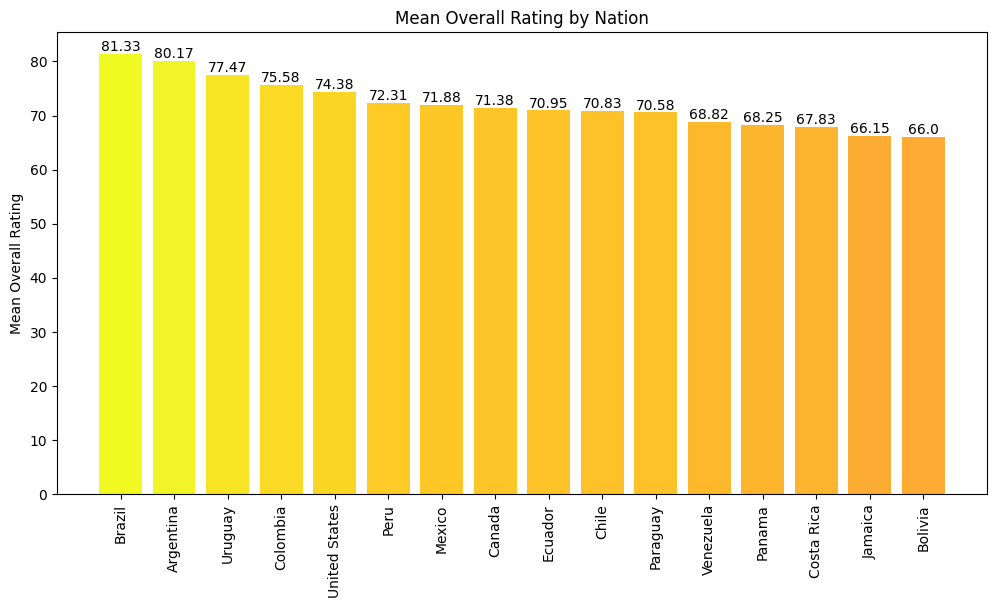

In [337]:
plt.figure(figsize=(12, 6))

nation_mean_overall = df.groupby('Nation')['Overall'].mean().sort_values(ascending=False)

# Plot the results with a color for each nation
plt.figure(figsize=(12, 6))
colors = plt.cm.plasma(nation_mean_overall / nation_mean_overall.max())

# Plot the bar chart with individual colors
bars = plt.bar(nation_mean_overall.index, nation_mean_overall, color=colors)
plt.xticks(rotation=90)  # Rotate x labels if necessary
plt.title('Mean Overall Rating by Nation')
plt.ylabel('Mean Overall Rating')

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.show()

Brazil has the strongest team of the tournament

<Figure size 1200x600 with 0 Axes>

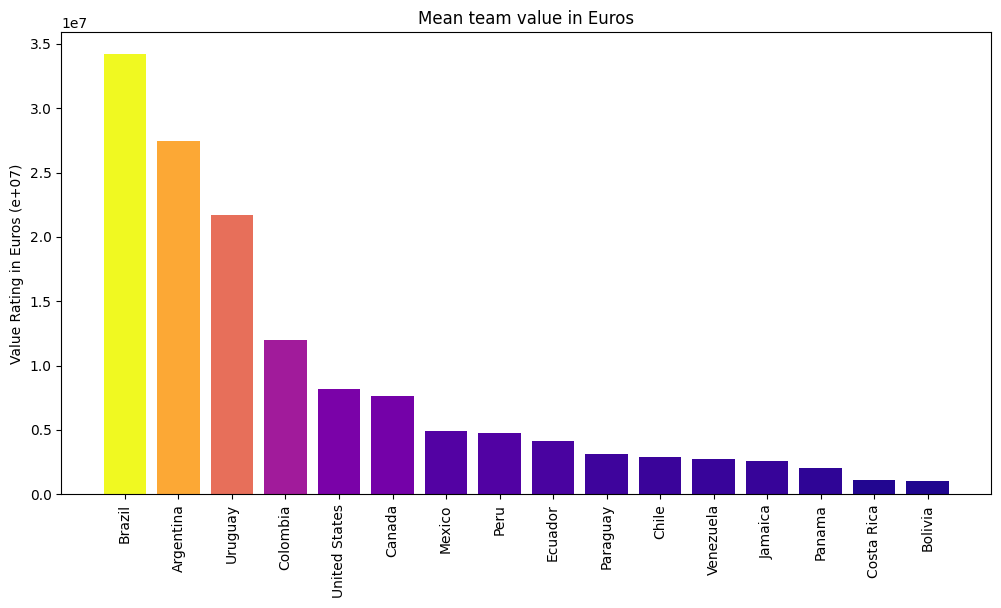

In [399]:
plt.figure(figsize=(12, 6))

nation_mean_overall = df.groupby('Nation')['Value(in Euro)'].mean().sort_values(ascending=False)

# Plot the results with a color for each nation
plt.figure(figsize=(12, 6))
colors = plt.cm.plasma(nation_mean_overall / nation_mean_overall.max())

# Plot the bar chart with individual colors
bars = plt.bar(nation_mean_overall.index, nation_mean_overall, color=colors)
plt.xticks(rotation=90)  # Rotate x labels if necessary
plt.title('Mean team value in Euros')
plt.ylabel('Value Rating in Euros (e+07)')



plt.show()

Consistently with the overall score, Brazil is also the team's most expensive country based on their players' value in the market, and Bolivia is the least.

<Figure size 1200x600 with 0 Axes>

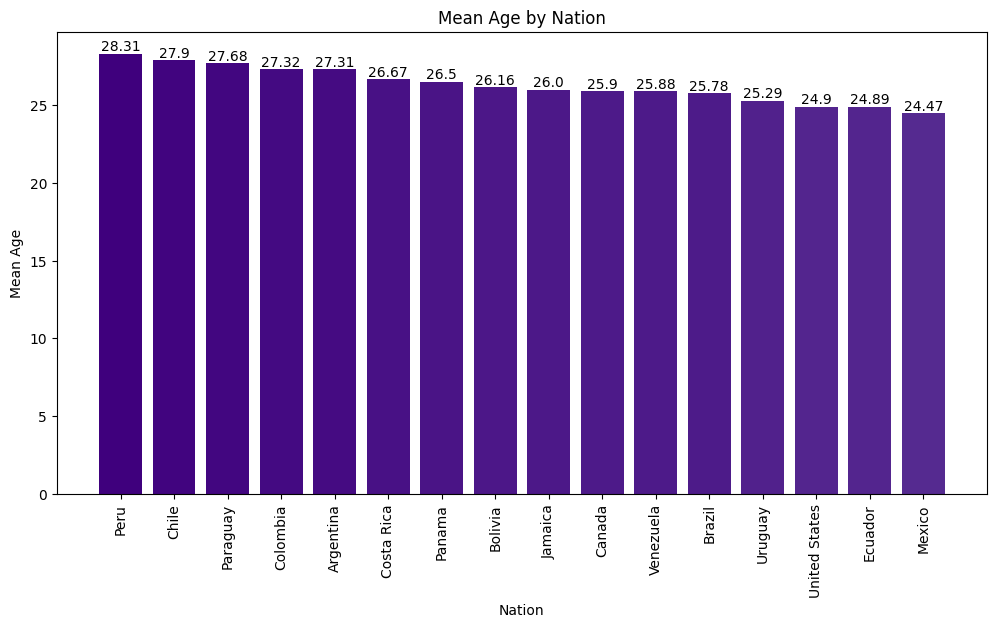

In [333]:
plt.figure(figsize=(12, 6))

nation_mean_overall = df.groupby('Nation')['Age'].mean().sort_values(ascending=False)

# Plot the results with a color for each nation
plt.figure(figsize=(12, 6))
colors = plt.cm.Purples(nation_mean_overall / nation_mean_overall.max())

# Plot the bar chart with individual colors
bars = plt.bar(nation_mean_overall.index, nation_mean_overall, color=colors)
plt.xticks(rotation=90)  # Rotate x labels if necessary
plt.title('Mean Age by Nation')
plt.xlabel('Nation')
plt.ylabel('Mean Age')

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.show()

Peru is the team with the oldest players on average and Mexico the one with the youngest.

26 Years old is the average age among teams.

In [396]:
# Changing rank date type to date time
ranking_FIFA['rank_date']=pd.to_datetime(ranking_FIFA['rank_date'])

# Adding a new column Year
ranking_FIFA['Year']=ranking_FIFA['rank_date'].dt.year

# Replacing Country names to standar
ranking_FIFA.replace('USA','United States',inplace=True)

# Keep only the last rank for each year
rank = ranking_FIFA.groupby(['Year', 'country_full']).last().reset_index()

# Filter the countries in the tournament
rank_tournament = rank[rank['country_full'].isin(df['Nation'].unique())]
rank_tournament_2024 = rank_tournament[rank_tournament['Year']== 2024].sort_values(by='rank', ascending=True)
rank_tournament_2024

,Year,country_full,rank,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
6469,2024,Argentina,1.0,ARG,1858.00,1855.20,0,CONMEBOL,2024-04-04
6488,2024,Brazil,5.0,BRA,1788.65,1784.09,0,CONMEBOL,2024-04-04
6662,2024,United States,11.0,United States,1681.13,1661.70,-2,CONCACAF,2024-04-04
6504,2024,Colombia,12.0,COL,1664.28,1655.29,-2,CONMEBOL,2024-04-04
6584,2024,Mexico,14.0,MEX,1661.11,1652.70,-1,CONCACAF,2024-04-04
6663,2024,Uruguay,15.0,URU,1659.39,1665.99,4,CONMEBOL,2024-04-04
6520,2024,Ecuador,31.0,ECU,1518.22,1519.20,0,CONMEBOL,2024-04-04
6609,2024,Peru,32.0,PER,1515.82,1512.68,-1,CONMEBOL,2024-04-04
6501,2024,Chile,42.0,CHI,1491.71,1489.82,0,CONMEBOL,2024-04-04
6606,2024,Panama,45.0,PAN,1475.62,1475.62,1,CONCACAF,2024-04-04


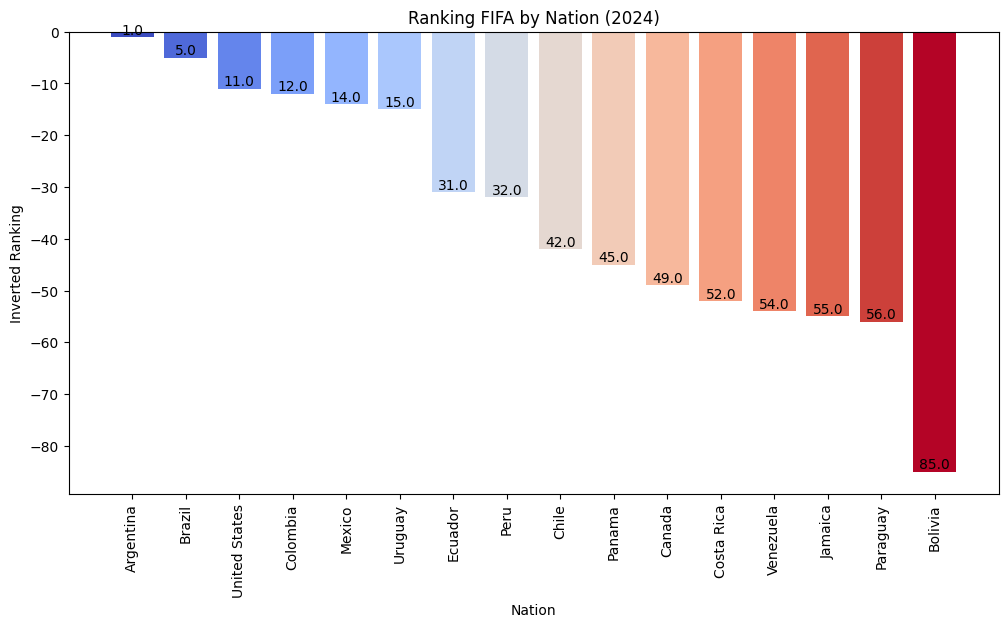

In [398]:
# Group by 'country_full' and get the most recent entry for each country
rank_tournament_2024_latest = rank_tournament_2024.groupby('country_full').last().reset_index()

# Invert the rankings for visualization (negative to positive)
rank_tournament_2024_latest['rank'] = rank_tournament_2024_latest['rank'] * (-1)

# Sort the DataFrame by the inverted rank
rank_tournament_2024_latest = rank_tournament_2024_latest.sort_values(by='rank', ascending=False)

# Plot the results with a color for each nation
plt.figure(figsize=(12, 6))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(rank_tournament_2024_latest)))

# Plot the bar chart with individual colors
bars = plt.bar(rank_tournament_2024_latest['country_full'], rank_tournament_2024_latest['rank'], color=colors)
plt.xticks(rotation=90)  # Rotate x labels if necessary
plt.title('Ranking FIFA by Nation (2024)')
plt.xlabel('Nation')
plt.ylabel('Inverted Ranking')

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(-yval, 2), ha='center', va='bottom')

plt.show()

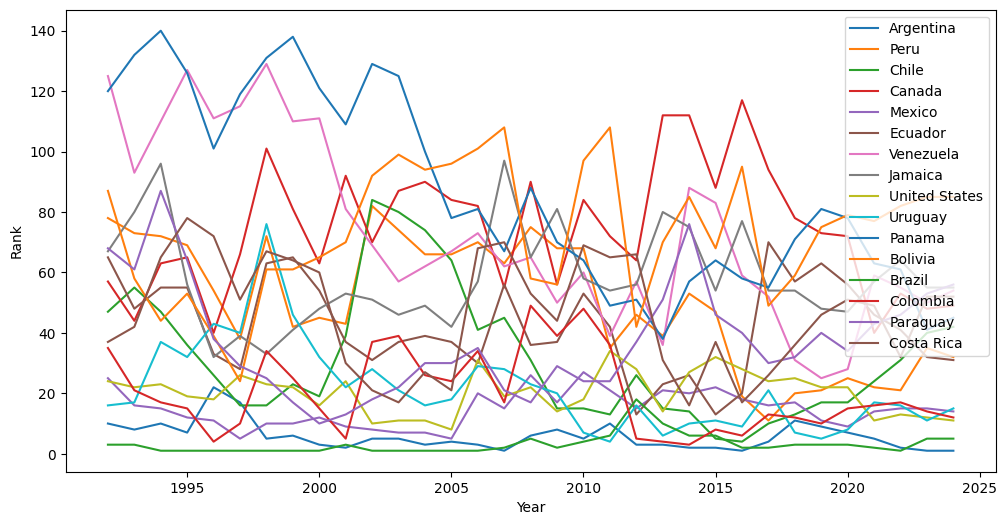

In [414]:
rank = ranking_FIFA.groupby(['Year', 'country_full']).last().reset_index()
# Rank for each team in competition
plt.figure(figsize=(12, 6))
for team in df['Nation'].unique():
    team_rank = rank[rank['country_full'] == team]
    plt.plot(team_rank['Year'], team_rank['rank'], label=team)
plt.xlabel('Year')
plt.ylabel('Rank')
# plt.title(f'Ranking FIFA for {team}')
plt.legend()
plt.show()

In [431]:
import plotly.express as px

rank_over_time = rank.groupby(['Year', 'country_full']).last().reset_index()

# Filter the countries in the tournament
rank_over_time = rank_over_time[rank_over_time['country_full'].isin(df['Nation'].unique())]

# Filter only the top Countries over time
top_countries = rank_over_time.groupby('country_full')['rank'].mean().sort_values(ascending=True).head(3)


rank_over_time_top = rank_over_time[rank_over_time['country_full'].isin(top_countries.index)]

# Create an interactive line plot for each country using Plotly
fig = px.line(rank_over_time_top, x='Year', y='rank', color='country_full', title='Ranking Over Time by Country')

fig.update_layout(xaxis_title='Year', yaxis_title='Rank')
fig.show()


# Data preparation for Predicition

The data frames we have so far are the following:

* df = list of players from web scraping with the values obtained from the FIFA 23 and 24 game database
* hs_df = historical data from previous games
* ranking_FIFA = Ranking FIFA of the different teams participating in the competition

In [310]:
# Change name to standar
df.replace('Estados Unidos','United States',inplace=True)

# Measuring the average overall score for each team based on the players listed to play this year tournament
team_avg_overall = df.groupby('Nation').mean('Overall').reset_index()
team_avg_overall

,Nation,Age,Overall,Value(in Euro),Height(in cm),Weight(in kg)
0,Argentina,27.310345,80.172414,2.741852e+07,179.666667,74.333333
1,Bolivia,26.157895,66.000000,1.066667e+06,181.666667,75.000000
2,Brazil,25.777778,81.333333,3.419375e+07,180.062500,74.625000
3,Canada,25.904762,71.380952,7.644444e+06,180.444444,75.833333
4,Chile,27.900000,70.833333,2.929833e+06,179.400000,74.266667
5,Colombia,27.315789,75.578947,1.195882e+07,180.000000,75.941176
6,Costa Rica,26.666667,67.833333,1.135000e+06,180.000000,72.400000
7,Ecuador,24.894737,70.947368,4.126667e+06,177.666667,71.933333
8,Jamaica,26.000000,66.153846,2.582500e+06,181.400000,74.900000
9,Mexico,24.470588,71.882353,4.938235e+06,176.647059,69.705882


In [118]:
# Creating list of countries that will play the tournament
playing_countries = team_avg_overall['Nation'].unique()
playing_countries

array(['Argentina', 'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia',
       'Costa Rica', 'Ecuador', 'Jamaica', 'Mexico', 'Panama', 'Paraguay',
       'Peru', 'United States', 'Uruguay', 'Venezuela'], dtype=object)

## Data from 2020 and after

I will use the data for matches that have been held from the 2020 and after

In [151]:
# Changing date type
hs_df['date'] = pd.to_datetime(hs_df['date'])

# Adding new column year
hs_df['Year'] = hs_df['date'] .dt.year

# # I will only take the played matches after 2020
hs_df_2020 = hs_df[hs_df['Year']>= 2020]

# Filter the results to include only the countries that will play the Copa America 2024
hs_df_ht = hs_df_2020[hs_df_2020['home_team'].isin(playing_countries)]
hs_df_at = hs_df_2020[hs_df_2020['away_team'].isin(playing_countries)]

hs_df_2020 = pd.concat([hs_df_ht, hs_df_at])
hs_df_2020.drop_duplicates(inplace=True)

# Drop the columns that are not useful
hs_df_2020.drop(columns=['city', 'country'] , inplace=True)

hs_df_2020.reset_index(drop=True, inplace=True)
hs_df_2020

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year
0,2020-01-15,Canada,Iceland,0.0,1.0,Friendly,True,2020
1,2020-02-01,United States,Costa Rica,1.0,0.0,Friendly,False,2020
2,2020-10-08,Paraguay,Peru,2.0,2.0,FIFA World Cup qualification,False,2020
3,2020-10-08,Uruguay,Chile,2.0,1.0,FIFA World Cup qualification,False,2020
4,2020-10-08,Argentina,Ecuador,1.0,0.0,FIFA World Cup qualification,False,2020
...,...,...,...,...,...,...,...,...
528,2024-03-23,England,Brazil,0.0,1.0,Friendly,False,2024
529,2024-03-24,Guatemala,Venezuela,0.0,0.0,Friendly,True,2024
530,2024-03-26,France,Chile,3.0,2.0,Friendly,False,2024
531,2024-03-26,Ivory Coast,Uruguay,2.0,1.0,Friendly,True,2024


In [152]:
# Adding the average team weight in each game played in the past.
hs_df_2020 = hs_df_2020.merge(team_avg_overall[['Nation', 'Overall']],
                           left_on='home_team',
                           right_on='Nation',
                           suffixes=('', '_Overall_HT'))

# Drop the redundant 'Nation' column
hs_df_2020.drop(columns=['Nation'], inplace=True)

# Second merge: Away Team overall
hs_df_2020 = hs_df_2020.merge(team_avg_overall[['Nation', 'Overall']],
                                  left_on='away_team',
                                  right_on='Nation',
                                  suffixes=('_HT', '_AT'))

# Drop the redundant 'Nation' column from the second merge
hs_df_2020.drop(columns=['Nation'], inplace=True)

# Difference between each team based on the overall
hs_df_2020['Overall_Diff'] = hs_df_2020['Overall_HT'] - hs_df_2020['Overall_AT']

hs_df_2020

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year,Overall_HT,Overall_AT,Overall_Diff
0,2021-10-13,Canada,Panama,4.0,1.0,FIFA World Cup qualification,False,2021,71.380952,68.250000,3.130952
1,2020-11-16,United States,Panama,6.0,2.0,Friendly,True,2020,74.380952,68.250000,6.130952
2,2022-03-27,United States,Panama,5.0,1.0,FIFA World Cup qualification,False,2022,74.380952,68.250000,6.130952
3,2023-07-12,United States,Panama,1.0,1.0,Gold Cup,False,2023,74.380952,68.250000,6.130952
4,2022-06-11,Uruguay,Panama,5.0,0.0,Friendly,False,2022,77.470588,68.250000,9.220588
...,...,...,...,...,...,...,...,...,...,...,...
241,2022-11-16,Peru,Paraguay,1.0,0.0,Friendly,False,2022,72.307692,70.578947,1.728745
242,2021-06-24,Chile,Paraguay,0.0,2.0,Copa América,True,2021,70.833333,70.578947,0.254386
243,2021-10-10,Chile,Paraguay,2.0,0.0,FIFA World Cup qualification,False,2021,70.833333,70.578947,0.254386
244,2023-03-27,Chile,Paraguay,3.0,2.0,Friendly,False,2023,70.833333,70.578947,0.254386


In [153]:
# Changing rank date type to date time
ranking_FIFA['rank_date']=pd.to_datetime(ranking_FIFA['rank_date'])

# Adding a new column Year
ranking_FIFA['Year']=ranking_FIFA['rank_date'].dt.year

# Replacing Country names to standar
ranking_FIFA.replace('USA','United States',inplace=True)

# # Filter FIFA ranking
ranking_FIFA_2020 = ranking_FIFA[ranking_FIFA['Year']>= 2020]

# Keep only the last rank for each year
ranking_FIFA_2020 = ranking_FIFA_2020.groupby(['Year', 'country_full']).last().reset_index()

ranking_FIFA_2020

,Year,country_full,rank,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,2020,Afghanistan,150.0,AFG,1052.00,1052.00,0,AFC,2020-12-10
1,2020,Albania,66.0,ALB,1360.00,1360.00,0,UEFA,2020-12-10
2,2020,Algeria,31.0,ALG,1488.00,1488.00,0,CAF,2020-12-10
3,2020,American Samoa,192.0,ASA,900.00,900.00,0,OFC,2020-12-10
4,2020,Andorra,151.0,AND,1048.00,1048.00,0,UEFA,2020-12-10
...,...,...,...,...,...,...,...,...,...
1048,2024,Vietnam,115.0,VIE,1164.54,1194.58,10,AFC,2024-04-04
1049,2024,Wales,29.0,WAL,1531.38,1521.88,0,UEFA,2024-04-04
1050,2024,Yemen,156.0,YEM,1017.05,1027.94,5,AFC,2024-04-04
1051,2024,Zambia,86.0,ZAM,1278.26,1275.71,-1,CAF,2024-04-04


In [154]:
# Adding ranking FIFA to played_games dataset
hs_df_2020 = hs_df_2020.merge(ranking_FIFA[['Year', 'rank','country_full']],
                                  left_on=['Year', 'home_team'],
                                  right_on=['Year', 'country_full'],
                                  suffixes=('', '_rank_FIFA_HT'))
# Drop not necessary columns
hs_df_2020.drop(columns=['country_full'] , inplace=True)

# Adding ranking FIFA to played_games dataset
hs_df_2020 = hs_df_2020.merge(ranking_FIFA[['Year', 'rank','country_full']],
                                  left_on=['Year', 'away_team'],
                                  right_on=['Year', 'country_full'],
                                  suffixes=('_HT', '_AT'))
# Drop not necessary columns
hs_df_2020.drop(columns=['country_full'] , inplace=True)

# Difference between each team based on the overall
hs_df_2020['rank_FIFA_Diff'] = hs_df_2020['rank_HT'] - hs_df_2020['rank_AT']

hs_df_2020.drop_duplicates(subset='date',inplace=True)
hs_df_2020.reset_index(drop=True, inplace=True)
hs_df_2020

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year,Overall_HT,Overall_AT,Overall_Diff,rank_HT,rank_AT,rank_FIFA_Diff
0,2021-10-13,Canada,Panama,4.0,1.0,FIFA World Cup qualification,False,2021,71.380952,68.250000,3.130952,73.0,78.0,-5.0
1,2021-06-30,Mexico,Panama,3.0,0.0,Friendly,True,2021,71.882353,68.250000,3.632353,9.0,78.0,-69.0
2,2021-09-05,Jamaica,Panama,0.0,3.0,FIFA World Cup qualification,False,2021,66.153846,68.250000,-2.096154,47.0,78.0,-31.0
3,2021-11-12,Canada,Costa Rica,1.0,0.0,FIFA World Cup qualification,False,2021,71.380952,67.833333,3.547619,73.0,50.0,23.0
4,2021-06-03,Mexico,Costa Rica,0.0,0.0,CONCACAF Nations League,True,2021,71.882353,67.833333,4.049020,9.0,50.0,-41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2020-10-09,Colombia,Venezuela,3.0,0.0,FIFA World Cup qualification,False,2020,75.578947,68.818182,6.760766,10.0,25.0,-15.0
102,2021-07-10,Brazil,Argentina,0.0,1.0,Copa América,False,2021,81.333333,80.172414,1.160920,3.0,7.0,-4.0
103,2020-11-17,Ecuador,Colombia,6.0,1.0,FIFA World Cup qualification,False,2020,70.947368,75.578947,-4.631579,63.0,10.0,53.0
104,2020-10-08,Paraguay,Peru,2.0,2.0,FIFA World Cup qualification,False,2020,70.578947,72.307692,-1.728745,41.0,21.0,20.0


This data will be used to predict the champion from Copa America 2024, using only information from 2020 and after. At first glimpse, I see that the data is not enough, only 106 rows are available with the selected data to predict the games.

## Data from before and after 2020

As the before data is short, I decided to include all the historical data of matches between the teams in the dataset.

In [155]:
# Changing date type
hs_df['date'] = pd.to_datetime(hs_df['date'])

# Adding new column year
hs_df['Year'] = hs_df['date'] .dt.year

# Filter the results to include only the countries that will play the Copa America 2024
hs_df_ht = hs_df[hs_df['home_team'].isin(playing_countries)]
hs_df_at = hs_df[hs_df['away_team'].isin(playing_countries)]

hs_df = pd.concat([hs_df_ht, hs_df_at])
hs_df.drop_duplicates(inplace=True)

# Drop the columns that are not useful
hs_df.drop(columns=['city', 'country'] , inplace=True)

hs_df.reset_index(drop=True, inplace=True)
hs_df

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year
0,1885-11-28,United States,Canada,0.0,1.0,Friendly,False,1885
1,1886-11-25,United States,Canada,3.0,2.0,Friendly,False,1886
2,1902-07-20,Uruguay,Argentina,0.0,6.0,Friendly,False,1902
3,1903-09-13,Argentina,Uruguay,2.0,3.0,Friendly,False,1903
4,1905-08-15,Argentina,Uruguay,0.0,0.0,Copa Lipton,False,1905
...,...,...,...,...,...,...,...,...
7753,2024-03-23,England,Brazil,0.0,1.0,Friendly,False,2024
7754,2024-03-24,Guatemala,Venezuela,0.0,0.0,Friendly,True,2024
7755,2024-03-26,France,Chile,3.0,2.0,Friendly,False,2024
7756,2024-03-26,Ivory Coast,Uruguay,2.0,1.0,Friendly,True,2024


In [156]:
# Adding the average team weight in each game played in the past.
hs_df = hs_df.merge(team_avg_overall[['Nation', 'Overall']],
                           left_on='home_team',
                           right_on='Nation',
                           suffixes=('', '_Overall_HT'))

# Drop the redundant 'Nation' column
hs_df.drop(columns=['Nation'], inplace=True)

# Second merge: Away Team overall
hs_df = hs_df.merge(team_avg_overall[['Nation', 'Overall']],
                                  left_on='away_team',
                                  right_on='Nation',
                                  suffixes=('_HT', '_AT'))

# Drop the redundant 'Nation' column from the second merge
hs_df.drop(columns=['Nation'], inplace=True)

# Difference between each team based on the overall
hs_df['Overall_Diff'] = hs_df['Overall_HT'] - hs_df['Overall_AT']

hs_df

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year,Overall_HT,Overall_AT,Overall_Diff
0,1885-11-28,United States,Canada,0.0,1.0,Friendly,False,1885,74.380952,71.380952,3.000000
1,1886-11-25,United States,Canada,3.0,2.0,Friendly,False,1886,74.380952,71.380952,3.000000
2,1925-11-08,United States,Canada,6.0,1.0,Friendly,False,1925,74.380952,71.380952,3.000000
3,1926-11-06,United States,Canada,6.0,2.0,Friendly,False,1926,74.380952,71.380952,3.000000
4,1957-07-06,United States,Canada,2.0,3.0,FIFA World Cup qualification,False,1957,74.380952,71.380952,3.000000
...,...,...,...,...,...,...,...,...,...,...,...
3577,2021-10-10,Panama,United States,1.0,0.0,FIFA World Cup qualification,False,2021,68.250000,74.380952,-6.130952
3578,1961-02-05,Colombia,United States,2.0,0.0,Friendly,False,1961,75.578947,74.380952,1.197995
3579,1995-07-22,Colombia,United States,4.0,1.0,Copa América,True,1995,75.578947,74.380952,1.197995
3580,2007-07-05,Colombia,United States,1.0,0.0,Copa América,True,2007,75.578947,74.380952,1.197995


In [157]:
# Changing rank date type to date time
ranking_FIFA['rank_date']=pd.to_datetime(ranking_FIFA['rank_date'])

# Adding a new column Year
ranking_FIFA['Year']=ranking_FIFA['rank_date'].dt.year

# Replacing Country names to standar
ranking_FIFA.replace('USA','United States',inplace=True)

# Keep only the last rank for each year
ranking_FIFA = ranking_FIFA.groupby(['Year', 'country_full']).last().reset_index()

ranking_FIFA

,Year,country_full,rank,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1992,Albania,86.0,ALB,14.00,0.00,86,UEFA,1992-12-31
1,1992,Algeria,30.0,ALG,39.00,0.00,30,CAF,1992-12-31
2,1992,Angola,102.0,ANG,10.00,0.00,102,CAF,1992-12-31
3,1992,Antigua and Barbuda,109.0,ATG,8.00,0.00,109,CONCACAF,1992-12-31
4,1992,Argentina,10.0,ARG,51.00,0.00,10,CONMEBOL,1992-12-31
...,...,...,...,...,...,...,...,...,...
6667,2024,Vietnam,115.0,VIE,1164.54,1194.58,10,AFC,2024-04-04
6668,2024,Wales,29.0,WAL,1531.38,1521.88,0,UEFA,2024-04-04
6669,2024,Yemen,156.0,YEM,1017.05,1027.94,5,AFC,2024-04-04
6670,2024,Zambia,86.0,ZAM,1278.26,1275.71,-1,CAF,2024-04-04


In [158]:
# Adding ranking FIFA to played_games dataset
hs_df = hs_df.merge(ranking_FIFA[['Year', 'rank','country_full']],
                                  left_on=['Year', 'home_team'],
                                  right_on=['Year', 'country_full'],
                                  suffixes=('', '_rank_FIFA_HT'))
# Drop not necessary columns
hs_df.drop(columns=['country_full'] , inplace=True)

# Adding ranking FIFA to played_games dataset
hs_df = hs_df.merge(ranking_FIFA[['Year', 'rank','country_full']],
                                  left_on=['Year', 'away_team'],
                                  right_on=['Year', 'country_full'],
                                  suffixes=('_HT', '_AT'))
# Drop not necessary columns
hs_df.drop(columns=['country_full'] , inplace=True)

# Difference between each team based on the overall
hs_df['rank_FIFA_Diff'] = hs_df['rank_HT'] - hs_df['rank_AT']

hs_df.drop_duplicates(subset='date',inplace=True)
hs_df.reset_index(drop=True, inplace=True)
hs_df

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year,Overall_HT,Overall_AT,Overall_Diff,rank_HT,rank_AT,rank_FIFA_Diff
0,1992-10-09,United States,Canada,0.0,0.0,Friendly,False,1992,74.380952,71.380952,3.000000,24.0,57.0,-33.0
1,1992-10-18,Jamaica,Canada,1.0,1.0,FIFA World Cup qualification,False,1992,66.153846,71.380952,-5.227106,67.0,57.0,10.0
2,1992-07-31,United States,Colombia,0.0,1.0,Friendly,False,1992,74.380952,75.578947,-1.197995,24.0,35.0,-11.0
3,1992-08-02,Mexico,Colombia,0.0,0.0,Friendly,True,1992,71.882353,75.578947,-3.696594,25.0,35.0,-10.0
4,1992-04-30,Uruguay,Brazil,1.0,0.0,Friendly,False,1992,77.470588,81.333333,-3.862745,16.0,3.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,1994-03-23,Brazil,Argentina,2.0,0.0,Friendly,False,1994,81.333333,80.172414,1.160920,1.0,10.0,-9.0
1051,2020-10-09,Brazil,Bolivia,5.0,0.0,FIFA World Cup qualification,False,2020,81.333333,66.000000,15.333333,3.0,79.0,-76.0
1052,1998-04-15,Mexico,Peru,1.0,0.0,Friendly,True,1998,71.882353,72.307692,-0.425339,10.0,72.0,-62.0
1053,2014-10-11,Argentina,Brazil,0.0,2.0,Superclásico de las Américas,True,2014,80.172414,81.333333,-1.160920,2.0,6.0,-4.0


This data will be used to predict the champion from Copa America 2024, using all the matches between the teams partcipating in the Copa America. The dataset is larger to the one above, we will see the results.

# Model and prediction

## Using data from 2020

In [159]:
# Create new column to determine who is the winner for each game
hs_df_2020['home_win']=hs_df_2020['home_score']>hs_df_2020['away_score']
hs_df_2020['away_win']=hs_df_2020['home_score']<hs_df_2020['away_score']
hs_df_2020['draw']=hs_df_2020['home_score']==hs_df_2020['away_score']

# Replace values
hs_df_2020['home_win'].replace(True,1,inplace=True)
hs_df_2020['home_win'].replace(False,0,inplace=True)

hs_df_2020['away_win'].replace(True,1,inplace=True)
hs_df_2020['away_win'].replace(False,0,inplace=True)

hs_df_2020['draw'].replace(True,1,inplace=True)
hs_df_2020['draw'].replace(False,0,inplace=True)

hs_df_2020

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year,Overall_HT,Overall_AT,Overall_Diff,rank_HT,rank_AT,rank_FIFA_Diff,home_win,away_win,draw
0,2021-10-13,Canada,Panama,4.0,1.0,FIFA World Cup qualification,False,2021,71.380952,68.250000,3.130952,73.0,78.0,-5.0,1,0,0
1,2021-06-30,Mexico,Panama,3.0,0.0,Friendly,True,2021,71.882353,68.250000,3.632353,9.0,78.0,-69.0,1,0,0
2,2021-09-05,Jamaica,Panama,0.0,3.0,FIFA World Cup qualification,False,2021,66.153846,68.250000,-2.096154,47.0,78.0,-31.0,0,1,0
3,2021-11-12,Canada,Costa Rica,1.0,0.0,FIFA World Cup qualification,False,2021,71.380952,67.833333,3.547619,73.0,50.0,23.0,1,0,0
4,2021-06-03,Mexico,Costa Rica,0.0,0.0,CONCACAF Nations League,True,2021,71.882353,67.833333,4.049020,9.0,50.0,-41.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2020-10-09,Colombia,Venezuela,3.0,0.0,FIFA World Cup qualification,False,2020,75.578947,68.818182,6.760766,10.0,25.0,-15.0,1,0,0
102,2021-07-10,Brazil,Argentina,0.0,1.0,Copa América,False,2021,81.333333,80.172414,1.160920,3.0,7.0,-4.0,0,1,0
103,2020-11-17,Ecuador,Colombia,6.0,1.0,FIFA World Cup qualification,False,2020,70.947368,75.578947,-4.631579,63.0,10.0,53.0,1,0,0
104,2020-10-08,Paraguay,Peru,2.0,2.0,FIFA World Cup qualification,False,2020,70.578947,72.307692,-1.728745,41.0,21.0,20.0,0,0,1


In [160]:
# Splitting the data for model prediction
X, y = hs_df_2020.loc[:,['rank_HT', 'rank_FIFA_Diff', 'Overall_Diff']], hs_df_2020['home_win']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Run the logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

In [161]:
# Shape of the datasets
for i in ['X_train', 'X_test', 'y_train', 'y_test']:
  print(f"Shape of {i}: {eval(i).shape}")

Shape of X_train: (84, 3)
Shape of X_test: (22, 3)
Shape of y_train: (84,)
Shape of y_test: (22,)


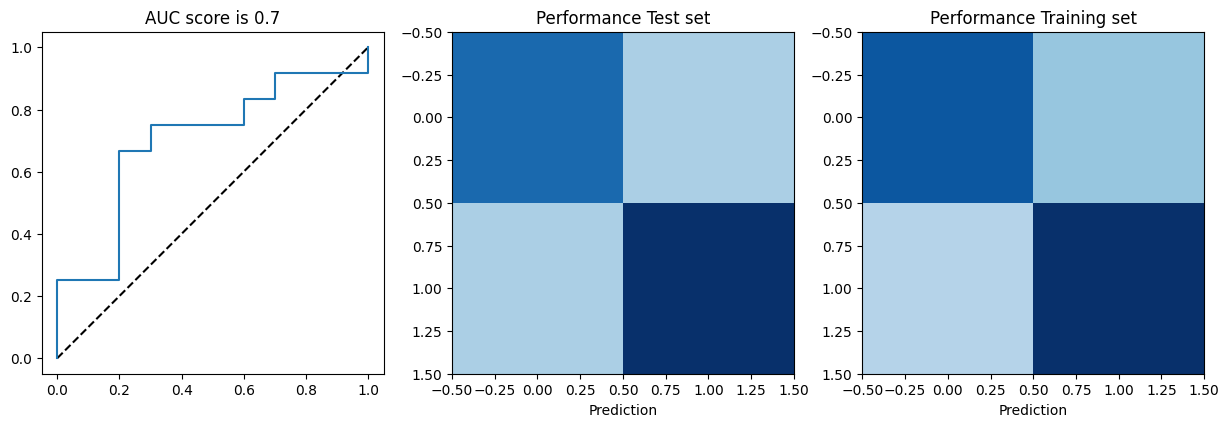

In [162]:
# Plot area under the curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max()))

ax.set_xlabel('Prediction')
ax.set_title('Performance Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max()))
ax.set_xlabel('Prediction')
ax.set_title('Performance Training set')
plot = plt.show()

We can see that the model's accuracy is 70% which is not enough. A reason for this can be the size of the data we are using to predict.

In [167]:
# Re-group each team by the group where they are locate in the tournament
championship_2020 = pd.DataFrame(playing_countries, columns=['Country'])
Group = {
   'A': [],
   'B': [],
   'C': [],
   'D': []
}

for team in championship_2020['Country']:
    if team in ['Argentina', 'Peru', 'Chile', 'Canada']:
        Group['A'].append(team)
    elif team in ['Mexico', 'Ecuador', 'Venezuela', 'Jamaica']:
        Group['B'].append(team)
    elif team in ['United States', 'Uruguay', 'Panama', 'Bolivia']:
        Group['C'].append(team)
    else:
        Group['D'].append(team)

championship_2020['Group'] = championship_2020['Country'].apply(lambda x: 'A' if x in Group['A'] else ('B' if x in Group['B'] else ('C' if x in Group['C'] else 'D')))
championship_2020

,Country,Group
0,Argentina,A
1,Bolivia,C
2,Brazil,D
3,Canada,A
4,Chile,A
5,Colombia,D
6,Costa Rica,D
7,Ecuador,B
8,Jamaica,B
9,Mexico,B


In [168]:
numerical_columns =hs_df_2020.select_dtypes(include=['float64', 'int64']).columns

# Calculate the average values for each column and team
stat_team = hs_df_2020.groupby('home_team')[numerical_columns].mean().reset_index()
stat_team

,home_team,home_score,away_score,Overall_HT,Overall_AT,Overall_Diff,rank_HT,rank_AT,rank_FIFA_Diff,home_win,away_win,draw
0,Argentina,2.100000,0.400000,80.172414,70.856147,9.316266,4.600000,39.900000,-35.300000,0.800000,0.000000,0.200000
1,Bolivia,1.000000,2.333333,66.000000,72.222652,-6.222652,79.000000,43.000000,36.000000,0.000000,1.000000,0.000000
2,Brazil,1.571429,0.428571,81.333333,73.299259,8.034074,3.000000,29.000000,-26.000000,0.714286,0.142857,0.142857
3,Canada,1.833333,1.166667,71.380952,70.995179,0.385774,55.333333,38.166667,17.166667,0.666667,0.333333,0.000000
4,Chile,1.250000,1.250000,70.833333,72.407121,-1.573787,26.250000,40.000000,-13.750000,0.500000,0.250000,0.250000
5,Colombia,1.375000,0.875000,75.578947,72.421759,3.157189,15.000000,31.125000,-16.125000,0.500000,0.250000,0.250000
6,Costa Rica,0.555556,1.000000,67.833333,69.101906,-1.268572,43.666667,52.000000,-8.333333,0.333333,0.666667,0.000000
7,Ecuador,2.400000,0.600000,70.947368,70.198246,0.749123,48.600000,45.600000,3.000000,0.800000,0.000000,0.200000
8,Jamaica,0.600000,1.200000,66.153846,70.228852,-4.075005,55.200000,50.800000,4.400000,0.200000,0.400000,0.400000
9,Mexico,1.384615,1.153846,71.882353,70.436026,1.446327,11.769231,46.384615,-34.615385,0.461538,0.307692,0.230769


In [169]:
# Create a sinlge table with the average values for each country
championship_2020 = championship_2020.merge(stat_team, left_on='Country', right_on='home_team', how='left')
championship_2020.drop(columns=['home_score',	'away_score', 'Overall_Diff', 'rank_FIFA_Diff', 'home_team', 'home_win',	'away_win',	'draw'], inplace=True)
championship_2020

,Country,Group,Overall_HT,Overall_AT,rank_HT,rank_AT
0,Argentina,A,80.172414,70.856147,4.600000,39.900000
1,Bolivia,C,66.000000,72.222652,79.000000,43.000000
2,Brazil,D,81.333333,73.299259,3.000000,29.000000
3,Canada,A,71.380952,70.995179,55.333333,38.166667
4,Chile,A,70.833333,72.407121,26.250000,40.000000
5,Colombia,D,75.578947,72.421759,15.000000,31.125000
6,Costa Rica,D,67.833333,69.101906,43.666667,52.000000
7,Ecuador,B,70.947368,70.198246,48.600000,45.600000
8,Jamaica,B,66.153846,70.228852,55.200000,50.800000
9,Mexico,B,71.882353,70.436026,11.769231,46.384615


### Model prediction

In [170]:
# Define margin
margin = 0.05

# Initialize points and total_prob columns
championship_2020['points'] = 0
championship_2020['total_prob'] = 0

# Ensure 'Group' is treated as a category
championship_2020['Group'] = championship_2020['Group'].astype('category')

# Iterate over unique group names
for group in sorted(championship_2020['Group'].unique()):
    print(f'___Group {group}:___')

    # Query the DataFrame for the current group
    group_teams = championship_2020.query('Group == @group').index

    # Iterate over combinations of teams in the group
    for home_team, away_team in combinations(group_teams, 2):
        home_country = championship_2020.loc[home_team, 'Country']
        away_country = championship_2020.loc[away_team, 'Country']
        print(f"{home_country} vs. {away_country}: ", end='')

        # Create a row with NaN values for the combination
        row = pd.DataFrame(np.array([[np.nan, np.nan]]), columns=['rank_FIFA_Diff', 'Overall_Diff'])

        # Calculate the differences
        row['rank_HT'] = championship_2020.loc[home_team, 'rank_HT']
        row['rank_FIFA_Diff'] = championship_2020.loc[home_team, 'rank_HT'] - championship_2020.loc[away_team, 'rank_AT']
        row['Overall_Diff'] = championship_2020.loc[home_team, 'Overall_HT'] - championship_2020.loc[away_team, 'Overall_AT']

        # Ensure columns are in the same order as used during training
        row = row[['rank_HT','rank_FIFA_Diff', 'Overall_Diff']]

        # Predict the win probability for the home team
        home_team_win_prob = model.predict_proba(row)[:, 1][0]
        championship_2020.loc[home_team, 'total_prob'] += home_team_win_prob
        championship_2020.loc[away_team, 'total_prob'] += 1 - home_team_win_prob

        # Determine the points based on win probability
        if home_team_win_prob <= 0.5 - margin:
            print(f"{away_country} wins with a prob of {1-home_team_win_prob:.3f}")
            championship_2020.loc[away_team, 'points'] += 3
        elif home_team_win_prob >= 0.5 + margin:
            print(f"{home_country} wins with a prob of {home_team_win_prob:.3f}")
            championship_2020.loc[home_team, 'points'] += 3
        else:
            print("draw")
            championship_2020.loc[home_team, 'points'] += 1
            championship_2020.loc[away_team, 'points'] += 1


___Group A:___
Argentina vs. Canada: Argentina wins with a prob of 0.688
Argentina vs. Chile: Argentina wins with a prob of 0.674
Argentina vs. Peru: Argentina wins with a prob of 0.763
Canada vs. Chile: Chile wins with a prob of 0.702
Canada vs. Peru: Peru wins with a prob of 0.595
Chile vs. Peru: Peru wins with a prob of 0.595
___Group B:___
Ecuador vs. Jamaica: Jamaica wins with a prob of 0.663
Ecuador vs. Mexico: Mexico wins with a prob of 0.653
Ecuador vs. Venezuela: Venezuela wins with a prob of 0.741
Jamaica vs. Mexico: Mexico wins with a prob of 0.897
Jamaica vs. Venezuela: Venezuela wins with a prob of 0.930
Mexico vs. Venezuela: draw
___Group C:___
Bolivia vs. Panama: Panama wins with a prob of 0.665
Bolivia vs. United States: United States wins with a prob of 0.845
Bolivia vs. Uruguay: Uruguay wins with a prob of 0.833
Panama vs. United States: United States wins with a prob of 0.740
Panama vs. Uruguay: Uruguay wins with a prob of 0.731
United States vs. Uruguay: United Stat

In [171]:
# Print the final results
championship_2020 = championship_2020.sort_values(by=['Group', 'points'], ascending=[True, False])
championship_2020.reset_index(drop=True, inplace=True)
championship_2020

,Country,Group,Overall_HT,Overall_AT,rank_HT,rank_AT,points,total_prob
0,Argentina,A,80.172414,70.856147,4.600000,39.900000,9,2.125789
1,Peru,A,72.307692,70.140435,22.750000,47.500000,6,1.426813
2,Chile,A,70.833333,72.407121,26.250000,40.000000,3,1.432920
3,Canada,A,71.380952,70.995179,55.333333,38.166667,0,1.014477
4,Mexico,B,71.882353,70.436026,11.769231,46.384615,7,2.012571
5,Venezuela,B,68.818182,72.222652,38.000000,42.666667,7,2.207415
6,Jamaica,B,66.153846,70.228852,55.200000,50.800000,3,0.836652
7,Ecuador,B,70.947368,70.198246,48.600000,45.600000,0,0.943361
8,United States,C,74.380952,69.904288,17.764706,41.352941,9,2.149305
9,Uruguay,C,77.470588,70.208508,14.400000,38.200000,6,1.998704


From the group stage we only 8 teams will continue playing to be consololidated as the champion from the Copa America 2024:
The teams that will continue on this path are:


1.   Argentina (1º Group A)
2.   Peru (2º Group A)
3.   Mexico (1º Group B)
4.   Venezuela (2º Group B)
5.   USA (1º Group C)
6.   Uruguay (2º Group C)
7.   Brazil (1º Group D)
8.   Colombia (2º Group D)



In [172]:
# Selecting teams for the next round
next_round = championship_2020.groupby('Group').nth([0, 1]).reset_index() # first 3
next_round[['Group','Country', 'points']]

,Group,Country,points
0,A,Argentina,9
1,A,Peru,6
2,B,Mexico,7
3,B,Venezuela,7
4,C,United States,9
5,C,Uruguay,6
6,D,Brazil,9
7,D,Colombia,4


In [173]:
# Defining games for the next round
keys=[0,3,2,1,4,7,6,5]

# Re arrange countries order
next_round = next_round.loc[keys]
next_round

,index,Country,Group,Overall_HT,Overall_AT,rank_HT,rank_AT,points,total_prob
0,0,Argentina,A,80.172414,70.856147,4.600000,39.900000,9,2.125789
3,5,Venezuela,B,68.818182,72.222652,38.000000,42.666667,7,2.207415
2,4,Mexico,B,71.882353,70.436026,11.769231,46.384615,7,2.012571
1,1,Peru,A,72.307692,70.140435,22.750000,47.500000,6,1.426813
4,8,United States,C,74.380952,69.904288,17.764706,41.352941,9,2.149305
7,13,Colombia,D,75.578947,72.421759,15.000000,31.125000,4,1.596083
6,12,Brazil,D,81.333333,73.299259,3.000000,29.000000,9,2.042408
5,9,Uruguay,C,77.470588,70.208508,14.400000,38.200000,6,1.998704


In [174]:
# Define each game
final_games = ['Best Eight', 'Semifinal', 'Final']

# Prediction for each game
for game in final_games:
    print("___Round {}___".format(game))
    iterations = int(len(next_round) / 2)
    winners = []

    for i in range(iterations):
        home_team = next_round.iloc[i * 2]['Country']
        away_team = next_round.iloc[i * 2 + 1]['Country']
        print("{} vs. {}: ".format(home_team, away_team), end='')

        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=['rank_HT', 'rank_FIFA_Diff', 'Overall_Diff'])

        row['rank_HT'] = championship_2020.loc[championship_2020['Country'] == home_team, 'rank_HT'].values[0]
        opp_rank = championship_2020.loc[championship_2020['Country'] == away_team, 'rank_AT'].values[0]
        home_team_pot = championship_2020.loc[championship_2020['Country'] == home_team, 'Overall_HT'].values[0]
        opp_pot = championship_2020.loc[championship_2020['Country'] == away_team, 'Overall_AT'].values[0]

        row['rank_FIFA_Diff'] = row['rank_HT'] - opp_rank
        row['Overall_Diff'] = home_team_pot - opp_pot

        home_team_win_prob = model.predict_proba(row)[:, 1][0]
        championship_2020.loc[championship_2020['Country'] == home_team, 'total_prob'] += home_team_win_prob
        championship_2020.loc[championship_2020['Country'] == away_team, 'total_prob'] += 1 - home_team_win_prob

        if home_team_win_prob <= 0.5:
            print("{0} wins with a probability of {1:.3f}".format(away_team, 1 - home_team_win_prob))
            winners.append(away_team)
        else:
            print("{0} wins with a probability of {1:.3f}".format(home_team, home_team_win_prob))
            winners.append(home_team)

    next_round = championship_2020.loc[championship_2020['Country'].isin(winners)]
    print("\n")


___Round Best Eight___
Argentina vs. Venezuela: Argentina wins with a probability of 0.695
Mexico vs. Peru: Mexico wins with a probability of 0.541
United States vs. Colombia: Colombia wins with a probability of 0.518
Brazil vs. Uruguay: Brazil wins with a probability of 0.717


___Round Semifinal___
Argentina vs. Mexico: Argentina wins with a probability of 0.751
Brazil vs. Colombia: Brazil wins with a probability of 0.636


___Round Final___
Argentina vs. Brazil: Argentina wins with a probability of 0.596




## Using all the matches

In [131]:
# Create new column to determine who is the winner for each game
hs_df['home_win']=hs_df['home_score']>hs_df['away_score']
hs_df['away_win']=hs_df['home_score']<hs_df['away_score']
hs_df['draw']=hs_df['home_score']==hs_df['away_score']

# Replace values
hs_df['home_win'].replace(True,1,inplace=True)
hs_df['home_win'].replace(False,0,inplace=True)

hs_df['away_win'].replace(True,1,inplace=True)
hs_df['away_win'].replace(False,0,inplace=True)

hs_df['draw'].replace(True,1,inplace=True)
hs_df['draw'].replace(False,0,inplace=True)

hs_df

,date,home_team,away_team,home_score,away_score,tournament,neutral,Year,Overall_HT,Overall_AT,Overall_Diff,rank_HT,rank_AT,rank_FIFA_Diff,home_win,away_win,draw
0,1992-10-09,United States,Canada,0.0,0.0,Friendly,False,1992,74.380952,71.380952,3.000000,24.0,57.0,-33.0,0,0,1
1,1992-10-18,Jamaica,Canada,1.0,1.0,FIFA World Cup qualification,False,1992,66.153846,71.380952,-5.227106,67.0,57.0,10.0,0,0,1
2,1992-07-31,United States,Colombia,0.0,1.0,Friendly,False,1992,74.380952,75.578947,-1.197995,24.0,35.0,-11.0,0,1,0
3,1992-08-02,Mexico,Colombia,0.0,0.0,Friendly,True,1992,71.882353,75.578947,-3.696594,25.0,35.0,-10.0,0,0,1
4,1992-04-30,Uruguay,Brazil,1.0,0.0,Friendly,False,1992,77.470588,81.333333,-3.862745,16.0,3.0,13.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,1994-03-23,Brazil,Argentina,2.0,0.0,Friendly,False,1994,81.333333,80.172414,1.160920,1.0,10.0,-9.0,1,0,0
1051,2020-10-09,Brazil,Bolivia,5.0,0.0,FIFA World Cup qualification,False,2020,81.333333,66.000000,15.333333,3.0,79.0,-76.0,1,0,0
1052,1998-04-15,Mexico,Peru,1.0,0.0,Friendly,True,1998,71.882353,72.307692,-0.425339,10.0,72.0,-62.0,1,0,0
1053,2014-10-11,Argentina,Brazil,0.0,2.0,Superclásico de las Américas,True,2014,80.172414,81.333333,-1.160920,2.0,6.0,-4.0,0,1,0


In [134]:
# Creating the dataset to predict champion
X, y = hs_df.loc[:,['rank_HT', 'rank_FIFA_Diff', 'Overall_Diff']], hs_df['home_win']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Run the logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

In [135]:
# Shape of the datasets
for i in ['X_train', 'X_test', 'y_train', 'y_test']:
  print(f"Shape of {i}: {eval(i).shape}")

Shape of X_train: (844, 3)
Shape of X_test: (211, 3)
Shape of y_train: (844,)
Shape of y_test: (211,)


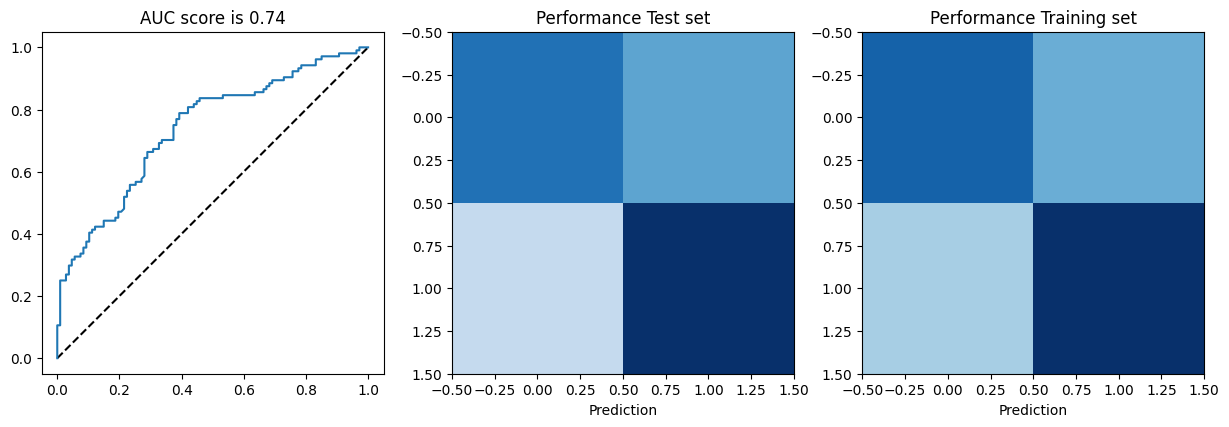

In [136]:
# Plot area under the curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max()))

ax.set_xlabel('Prediction')
ax.set_title('Performance Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max()))
ax.set_xlabel('Prediction')
ax.set_title('Performance Training set')
plot = plt.show()

In [139]:
# Re-group each team by the group where they are locate in the tournament
championship = pd.DataFrame(playing_countries, columns=['Country'])
Group = {
   'A': [],
   'B': [],
   'C': [],
   'D': []
}

for team in championship['Country']:
    if team in ['Argentina', 'Peru', 'Chile', 'Canada']:
        Group['A'].append(team)
    elif team in ['Mexico', 'Ecuador', 'Venezuela', 'Jamaica']:
        Group['B'].append(team)
    elif team in ['United States', 'Uruguay', 'Panama', 'Bolivia']:
        Group['C'].append(team)
    else:
        Group['D'].append(team)

championship['Group'] = championship['Country'].apply(lambda x: 'A' if x in Group['A'] else ('B' if x in Group['B'] else ('C' if x in Group['C'] else 'D')))
championship

,Country,Group
0,Argentina,A
1,Bolivia,C
2,Brazil,D
3,Canada,A
4,Chile,A
5,Colombia,D
6,Costa Rica,D
7,Ecuador,B
8,Jamaica,B
9,Mexico,B


In [140]:
numerical_columns =hs_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the average values for each column and team
stat_team = hs_df.groupby('home_team')[numerical_columns].mean().reset_index()
stat_team

,home_team,home_score,away_score,Overall_HT,Overall_AT,Overall_Diff,rank_HT,rank_AT,rank_FIFA_Diff,home_win,away_win,draw
0,Argentina,2.040541,0.716216,80.172414,72.224522,7.947892,5.743243,32.824324,-27.081081,0.662162,0.094595,0.243243
1,Bolivia,1.244898,1.204082,66.000000,72.193711,-6.193711,63.836735,42.224490,21.612245,0.326531,0.346939,0.326531
2,Brazil,2.218391,0.655172,81.333333,72.541540,8.791793,3.563218,31.275862,-27.712644,0.712644,0.103448,0.183908
3,Canada,1.035714,0.821429,71.380952,69.845676,1.535277,66.678571,44.357143,22.321429,0.428571,0.285714,0.285714
4,Chile,1.677419,1.145161,70.833333,72.638699,-1.805366,27.193548,35.693548,-8.500000,0.532258,0.241935,0.225806
5,Colombia,1.262295,0.836066,75.578947,72.229187,3.349760,19.803279,37.114754,-17.311475,0.442623,0.278689,0.278689
6,Costa Rica,1.492537,1.014925,67.833333,70.474585,-2.641251,41.686567,52.522388,-10.835821,0.462687,0.283582,0.253731
7,Ecuador,1.895833,0.895833,70.947368,71.335447,-0.388079,41.375000,46.375000,-5.000000,0.562500,0.208333,0.229167
8,Jamaica,1.000000,1.000000,66.153846,70.569478,-4.415632,56.045455,51.977273,4.068182,0.409091,0.363636,0.227273
9,Mexico,1.624113,0.836879,71.882353,71.712708,0.169645,13.347518,39.595745,-26.248227,0.546099,0.205674,0.248227


In [141]:
# Create a sinlge table with the average values for each country
championship = championship.merge(stat_team, left_on='Country', right_on='home_team', how='left')
championship.drop(columns=['home_score',	'away_score', 'Overall_Diff', 'rank_FIFA_Diff', 'home_team', 'home_win',	'away_win',	'draw'], inplace=True)
championship

,Country,Group,Overall_HT,Overall_AT,rank_HT,rank_AT
0,Argentina,A,80.172414,72.224522,5.743243,32.824324
1,Bolivia,C,66.000000,72.193711,63.836735,42.224490
2,Brazil,D,81.333333,72.541540,3.563218,31.275862
3,Canada,A,71.380952,69.845676,66.678571,44.357143
4,Chile,A,70.833333,72.638699,27.193548,35.693548
5,Colombia,D,75.578947,72.229187,19.803279,37.114754
6,Costa Rica,D,67.833333,70.474585,41.686567,52.522388
7,Ecuador,B,70.947368,71.335447,41.375000,46.375000
8,Jamaica,B,66.153846,70.569478,56.045455,51.977273
9,Mexico,B,71.882353,71.712708,13.347518,39.595745


### Model prediction

In [142]:
# Define margin
margin = 0.05

# Initialize points and total_prob columns
championship['points'] = 0
championship['total_prob'] = 0

# Ensure 'Group' is treated as a category
championship['Group'] = championship['Group'].astype('category')

# Iterate over unique group names
for group in sorted(championship['Group'].unique()):
    print(f'___Group {group}:___')

    # Query the DataFrame for the current group
    group_teams = championship.query('Group == @group').index

    # Iterate over combinations of teams in the group
    for home_team, away_team in combinations(group_teams, 2):
        home_country = championship.loc[home_team, 'Country']
        away_country = championship.loc[away_team, 'Country']
        print(f"{home_country} vs. {away_country}: ", end='')

        # Create a row with NaN values for the combination
        row = pd.DataFrame(np.array([[np.nan, np.nan]]), columns=['rank_FIFA_Diff', 'Overall_Diff'])

        # Calculate the differences
        row['rank_HT'] = championship.loc[home_team, 'rank_HT']
        row['rank_FIFA_Diff'] = championship.loc[home_team, 'rank_HT'] - championship.loc[away_team, 'rank_AT']
        row['Overall_Diff'] = championship.loc[home_team, 'Overall_HT'] - championship.loc[away_team, 'Overall_AT']

        # Ensure columns are in the same order as used during training
        row = row[['rank_HT','rank_FIFA_Diff', 'Overall_Diff']]

        # Predict the win probability for the home team
        home_team_win_prob = model.predict_proba(row)[:, 1][0]
        championship.loc[home_team, 'total_prob'] += home_team_win_prob
        championship.loc[away_team, 'total_prob'] += 1 - home_team_win_prob

        # Determine the points based on win probability
        if home_team_win_prob <= 0.5 - margin:
            print(f"{away_country} wins with a prob of {1-home_team_win_prob:.3f}")
            championship.loc[away_team, 'points'] += 3
        elif home_team_win_prob >= 0.5 + margin:
            print(f"{home_country} wins with a prob of {home_team_win_prob:.3f}")
            championship.loc[home_team, 'points'] += 3
        else:
            print("draw")
            championship.loc[home_team, 'points'] += 1
            championship.loc[away_team, 'points'] += 1


___Group A:___
Argentina vs. Canada: Argentina wins with a prob of 0.717
Argentina vs. Chile: Argentina wins with a prob of 0.641
Argentina vs. Peru: Argentina wins with a prob of 0.680
Canada vs. Chile: Chile wins with a prob of 0.719
Canada vs. Peru: Peru wins with a prob of 0.668
Chile vs. Peru: draw
___Group B:___
Ecuador vs. Jamaica: draw
Ecuador vs. Mexico: draw
Ecuador vs. Venezuela: Venezuela wins with a prob of 0.551
Jamaica vs. Mexico: Mexico wins with a prob of 0.725
Jamaica vs. Venezuela: Venezuela wins with a prob of 0.728
Mexico vs. Venezuela: draw
___Group C:___
Bolivia vs. Panama: Panama wins with a prob of 0.714
Bolivia vs. United States: United States wins with a prob of 0.777
Bolivia vs. Uruguay: Uruguay wins with a prob of 0.772
Panama vs. United States: United States wins with a prob of 0.775
Panama vs. Uruguay: Uruguay wins with a prob of 0.768
United States vs. Uruguay: United States wins with a prob of 0.583
___Group D:___
Brazil vs. Colombia: Brazil wins with a

In [143]:
# Print the groups and teams with how many points they have scored after the group stage.
championship = championship.sort_values(by=['Group', 'points'], ascending=[True, False])
championship.reset_index(drop=True, inplace=True)
championship

,Country,Group,Overall_HT,Overall_AT,rank_HT,rank_AT,points,total_prob
0,Argentina,A,80.172414,72.224522,5.743243,32.824324,9,2.038289
1,Chile,A,70.833333,72.638699,27.193548,35.693548,4,1.587474
2,Peru,A,72.307692,71.894992,48.814815,43.388889,4,1.477775
3,Canada,A,71.380952,69.845676,66.678571,44.357143,0,0.896462
4,Venezuela,B,68.818182,72.240852,74.090909,42.200000,7,1.732463
5,Mexico,B,71.882353,71.712708,13.347518,39.595745,5,1.820133
6,Ecuador,B,70.947368,71.335447,41.375000,46.375000,2,1.425905
7,Jamaica,B,66.153846,70.569478,56.045455,51.977273,1,1.021499
8,United States,C,74.380952,71.397207,20.201299,36.707792,9,2.135368
9,Uruguay,C,77.470588,72.033801,24.244898,42.755102,6,1.956646


From the group stage we only 8 teams will continue playing to be consololidated as the champion from the Copa America 2024:
The teams that will continue on this path are:


1.   Argentina (1º Group A)
2.   Chile (2º Group A)
3.   Venezuela (1º Group B)
4.   Mexico (2º Group B)
5.   USA (1º Group C)
6.   Uruguay (2º Group C)
7.   Brazil (1º Group D)
8.   Colombia (2º Group D)



In [144]:
# Selecting teams for the nextt round
next_round = championship.groupby('Group').nth([0, 1]).reset_index() # first 2
next_round[['Group','Country', 'points']]

,Group,Country,points
0,A,Argentina,9
1,A,Chile,4
2,B,Venezuela,7
3,B,Mexico,5
4,C,United States,9
5,C,Uruguay,6
6,D,Brazil,9
7,D,Colombia,6


In [145]:
# Defining games for the next round
keys=[0,3,2,1,4,7,6,5]

# Re arrange countries order
next_round = next_round.loc[keys]
next_round

,index,Country,Group,Overall_HT,Overall_AT,rank_HT,rank_AT,points,total_prob
0,0,Argentina,A,80.172414,72.224522,5.743243,32.824324,9,2.038289
3,5,Mexico,B,71.882353,71.712708,13.347518,39.595745,5,1.820133
2,4,Venezuela,B,68.818182,72.240852,74.090909,42.200000,7,1.732463
1,1,Chile,A,70.833333,72.638699,27.193548,35.693548,4,1.587474
4,8,United States,C,74.380952,71.397207,20.201299,36.707792,9,2.135368
7,13,Colombia,D,75.578947,72.229187,19.803279,37.114754,6,1.620904
6,12,Brazil,D,81.333333,72.541540,3.563218,31.275862,9,2.115401
5,9,Uruguay,C,77.470588,72.033801,24.244898,42.755102,6,1.956646


In [146]:
# Define each game
final_games = ['Best Eight', 'Semifinal', 'Final']

# Prediction for each game
for game in final_games:
    print("___Round {}___".format(game))
    iterations = int(len(next_round) / 2)
    winners = []

    for i in range(iterations):
        home_team = next_round.iloc[i * 2]['Country']
        away_team = next_round.iloc[i * 2 + 1]['Country']
        print("{} vs. {}: ".format(home_team, away_team), end='')

        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=['rank_HT', 'rank_FIFA_Diff', 'Overall_Diff'])

        row['rank_HT'] = championship.loc[championship['Country'] == home_team, 'rank_HT'].values[0]
        opp_rank = championship.loc[championship['Country'] == away_team, 'rank_AT'].values[0]
        home_team_pot = championship.loc[championship['Country'] == home_team, 'Overall_HT'].values[0]
        opp_pot = championship.loc[championship['Country'] == away_team, 'Overall_AT'].values[0]

        row['rank_FIFA_Diff'] = row['rank_HT'] - opp_rank
        row['Overall_Diff'] = home_team_pot - opp_pot

        home_team_win_prob = model.predict_proba(row)[:, 1][0]
        championship.loc[championship['Country'] == home_team, 'total_prob'] += home_team_win_prob
        championship.loc[championship['Country'] == away_team, 'total_prob'] += 1 - home_team_win_prob

        if home_team_win_prob <= 0.5:
            print("{0} wins with a probability of {1:.3f}".format(away_team, 1 - home_team_win_prob))
            winners.append(away_team)
        else:
            print("{0} wins with a probability of {1:.3f}".format(home_team, home_team_win_prob))
            winners.append(home_team)

    next_round = championship.loc[championship['Country'].isin(winners)]
    print("\n")


___Round Best Eight___
Argentina vs. Mexico: Argentina wins with a probability of 0.669
Venezuela vs. Chile: Chile wins with a probability of 0.813
United States vs. Colombia: United States wins with a probability of 0.562
Brazil vs. Uruguay: Brazil wins with a probability of 0.689


___Round Semifinal___
Argentina vs. Chile: Argentina wins with a probability of 0.641
United States vs. Brazil: United States wins with a probability of 0.539


___Round Final___
Argentina vs. United States: Argentina wins with a probability of 0.664




Wow, what a thrilling journey through the Copa America 2024! Argentina has emerged as the ultimate champion with a probability score of 0.66 in the final against Brazil! Congratulations, Argentina! ⭐⭐⭐